In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

plots = {}

In [3]:
folder_path = './Aruco_dataset'
files = os.listdir(folder_path)
print(files)

['dataset3.csv', 'dataset4.csv', 'dataset1.csv', 'dataset2.csv']


In [ ]:
df = pd.read_csv(folder_path+'/dataset1.csv')
df.shape

(27577, 40)

# Time series

In [4]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0]]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 5
X, y = df_to_X_y(df, window_size)
X.shape, y.shape

NameError: name 'df' is not defined

In [ ]:
total = len(X)  # should be 27572
split1 = int(total * 0.70)
split2 = split1 + int(total * 0.15)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((19153, 5, 40),
 (19153, 1),
 (4104, 5, 40),
 (4104, 1),
 (4105, 5, 40),
 (4105, 1))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

nsamples, ntimesteps, nfeatures = X_train.shape
X_train_2d = X_train.reshape(-1, nfeatures)
X_val_2d   = X_val.reshape(-1, nfeatures)
X_test_2d  = X_test.reshape(-1, nfeatures)

scaler = StandardScaler()
scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(nsamples, ntimesteps, nfeatures)
X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

### CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten

input_layer = Input(shape=(window_size, 40))

x = Conv1D(64, kernel_size=2)(input_layer)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1441 - root_mean_squared_error: 1.0407 - val_loss: 0.1545 - val_root_mean_squared_error: 0.3931
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0899 - root_mean_squared_error: 0.2997 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2816
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2325
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0365 - root_mean_squared_error: 0.1909 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1930
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1457
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3m

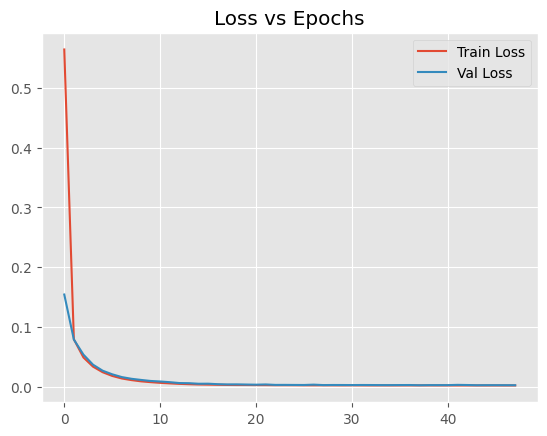

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
#save model
model.save(folder_path + "/models/cnn_40f_rand.keras")

In [ ]:
#load model
from tensorflow import keras

model = keras.models.load_model(folder_path + "/models/cnn_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


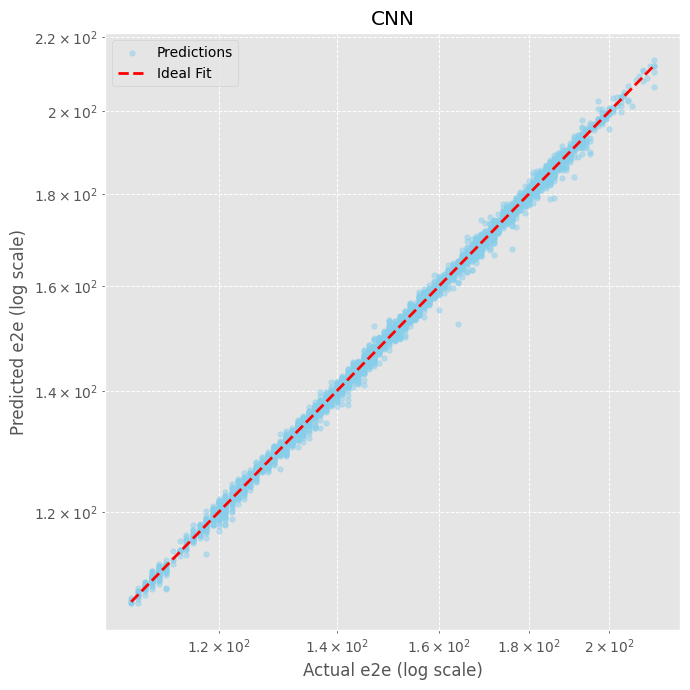

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("CNN")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["CNN"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.7866
MSE:  1.1692
RMSE: 1.0813
R²:   0.9978


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step


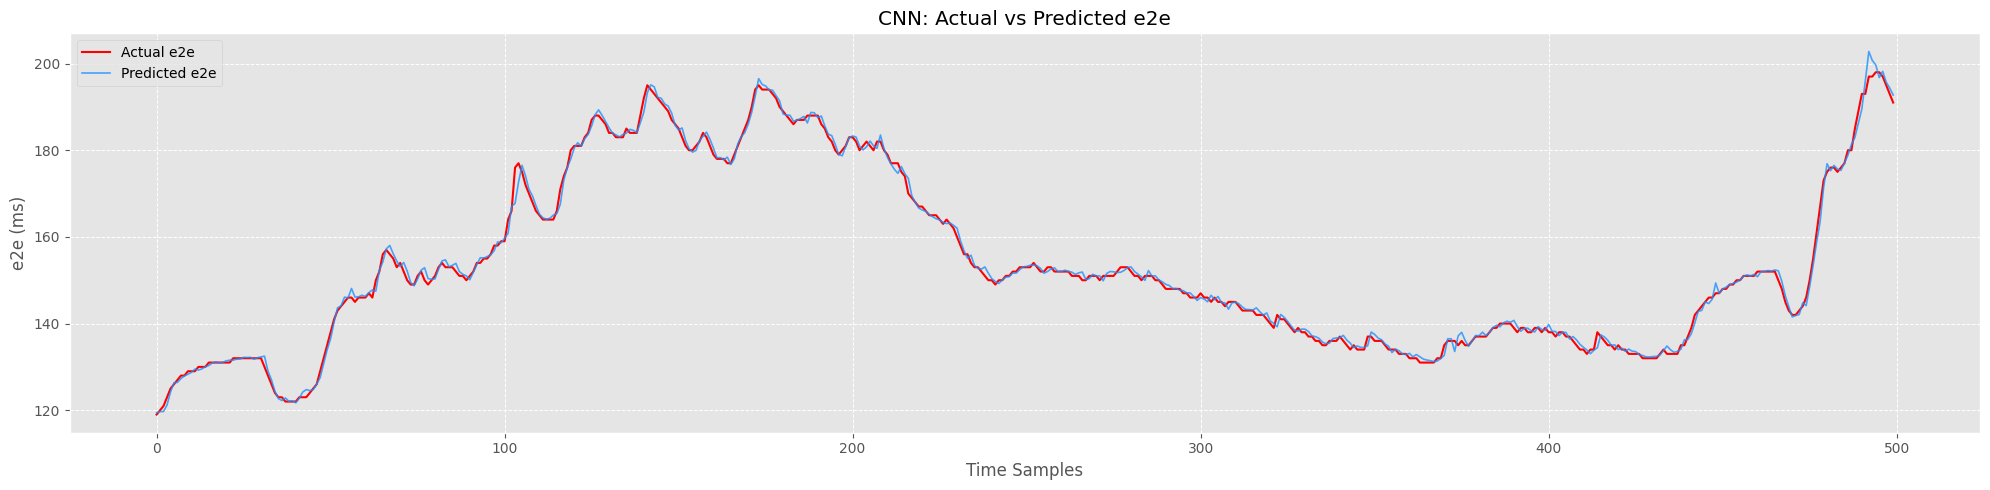

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### GRU

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D,  GRU
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = GRU(64)(input_layer)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        20,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,881 (81.57 KB)

 Trainable params: 20,881 (81.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3417 - root_mean_squared_error: 0.5701 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0406 - root_mean_squared_error: 0.2011 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1384
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7m

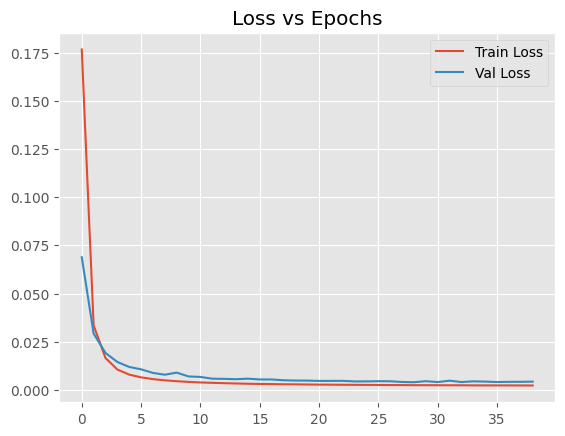

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
#save model
model.save(folder_path + "/models/gru_40f_rand.keras")

In [ ]:
#load model
from tensorflow import keras

model = keras.models.load_model(folder_path + "/models/gru_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


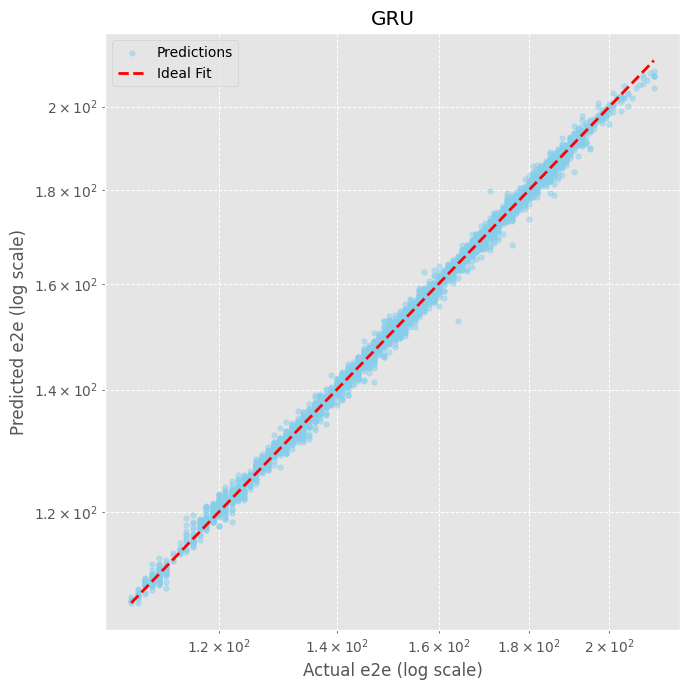

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("GRU")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["GRU"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.9317
MSE:  1.5670
RMSE: 1.2518
R²:   0.9971


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


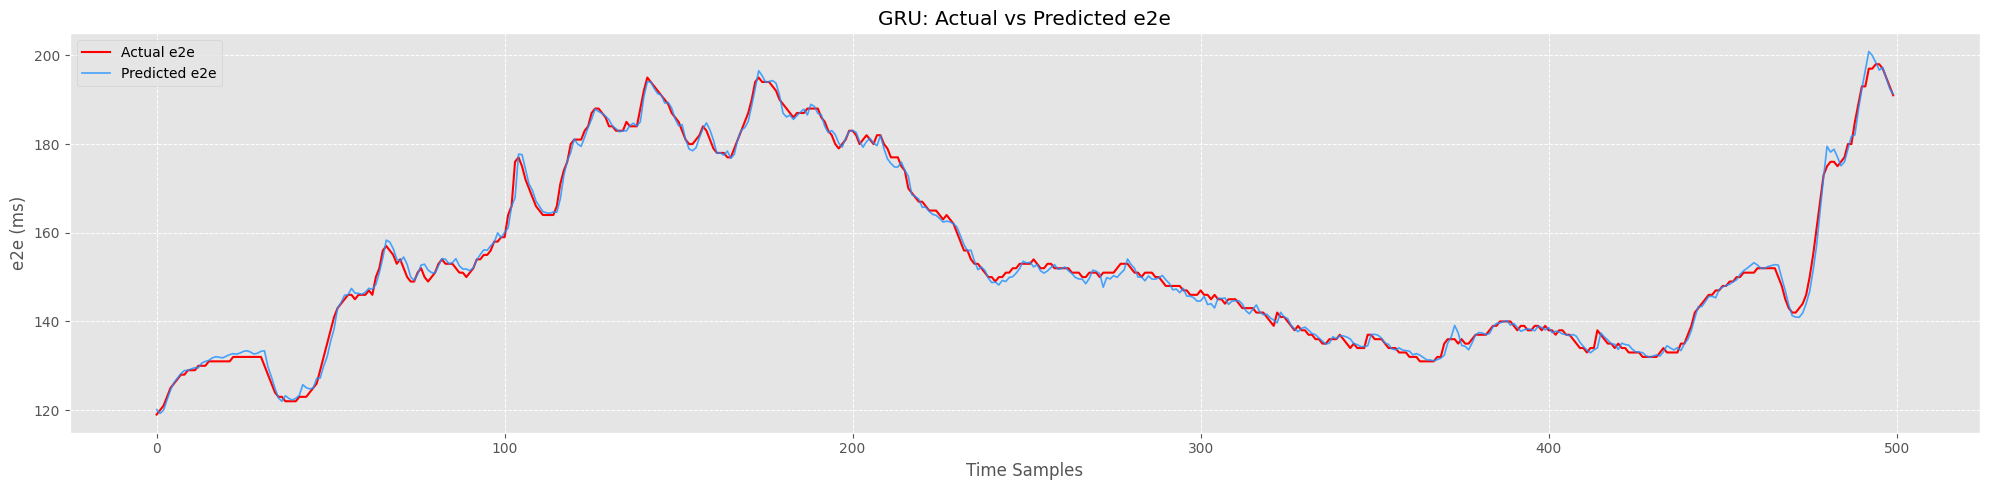

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("GRU: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = LSTM(64)(input_layer)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,409 (107.07 KB)

 Trainable params: 27,409 (107.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3293 - root_mean_squared_error: 0.5550 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2585
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0384 - root_mean_squared_error: 0.1956 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1933
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1623
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1302
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6m

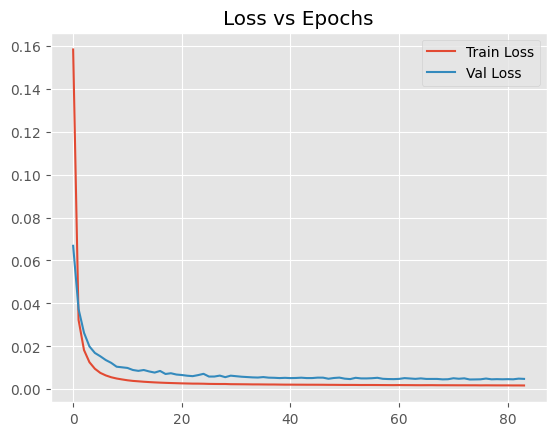

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
#save model
model.save(folder_path + "/models/lstm_40f_rand.keras")

In [ ]:
#load model
from tensorflow import keras

model = keras.models.load_model(folder_path + "/models/lstm_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


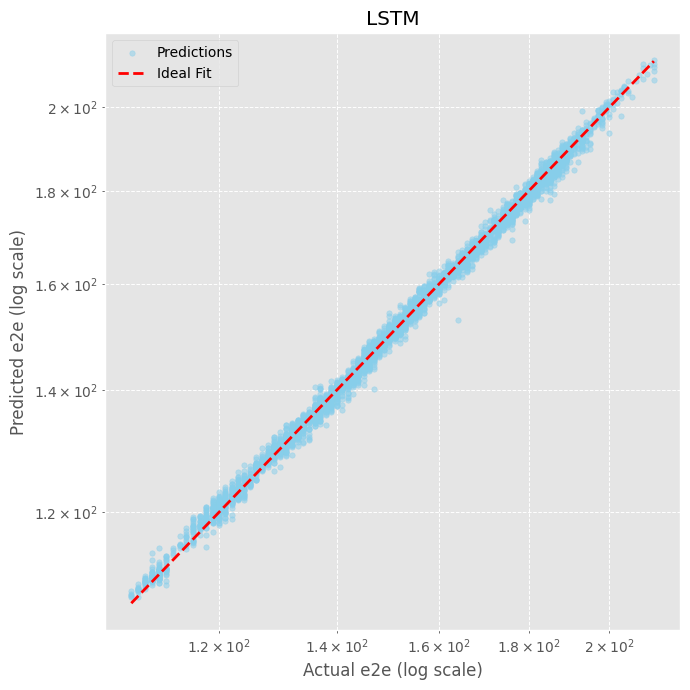

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("LSTM")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["LSTM"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  1.0176
MSE:  1.8030
RMSE: 1.3427
R²:   0.9967


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


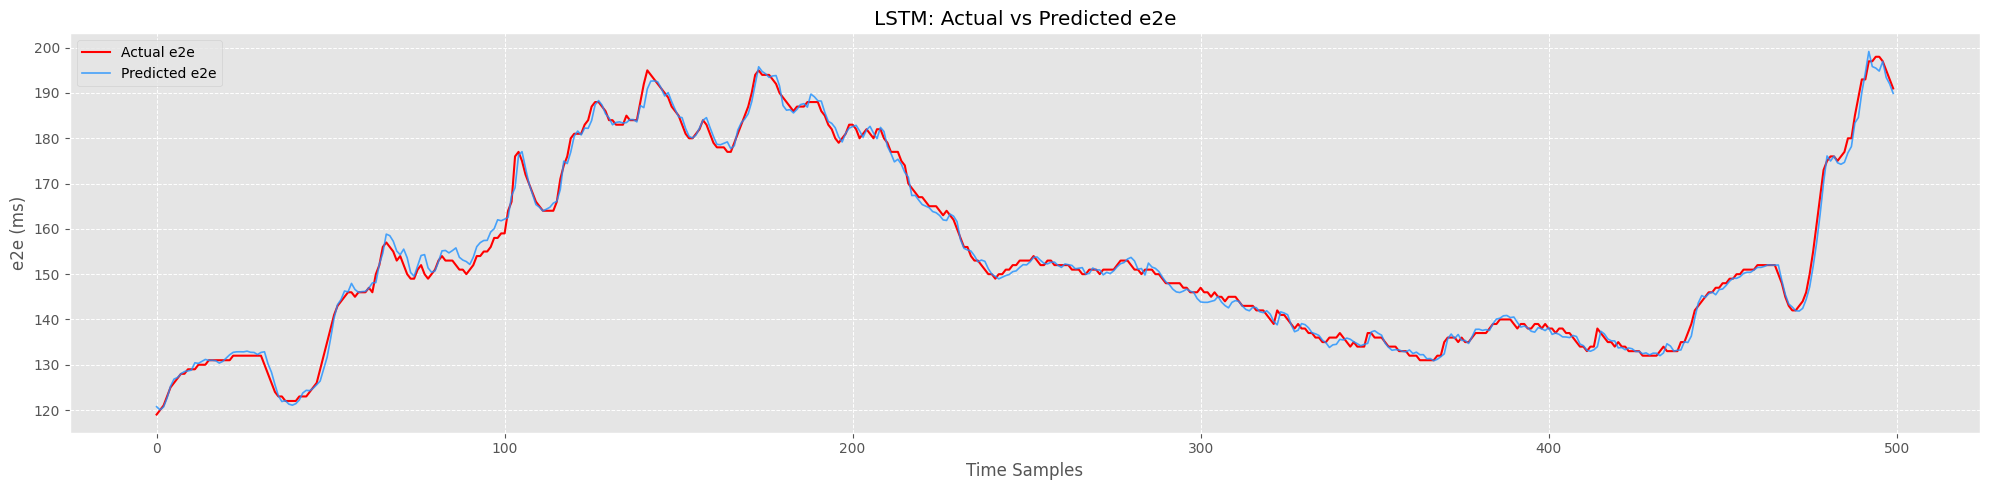

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### CNN + LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = Conv1D(64, kernel_size=2, padding='same', activation='relu')(input_layer)
#x = MaxPooling1D(pool_size=2)(x)
#x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 64)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737 (151.32 KB)

 Trainable params: 38,737 (151.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=32
)

Epoch 1/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.6835 - root_mean_squared_error: 0.8198 - val_loss: 0.2838 - val_root_mean_squared_error: 0.5328
Epoch 2/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578 - val_loss: 0.2548 - val_root_mean_squared_error: 0.5048
Epoch 3/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1922 - root_mean_squared_error: 0.4383 - val_loss: 0.2461 - val_root_mean_squared_error: 0.4961
Epoch 4/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1929 - root_mean_squared_error: 0.4390 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4914
Epoch 5/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1822 - root_mean_squared_error: 0.4268 - val_loss: 0.2423 - val_root_mean_squared_error: 0.4922
Epoch 6/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1712 - root_mean_squared_error: 0.4136 - val_loss: 0.2263 - val_root_mean_squared_error: 0.4757
Epoch 7/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s

KeyboardInterrupt: 

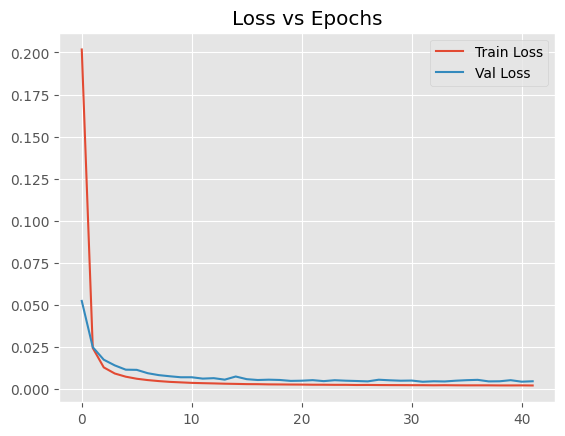

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
#save model
model.save(folder_path + "/models/cnn_lstm_40f_rand.keras")

In [ ]:
#load model
from tensorflow import keras

model = keras.models.load_model(folder_path + "/models/cnn_lstm_40f_rand.keras")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


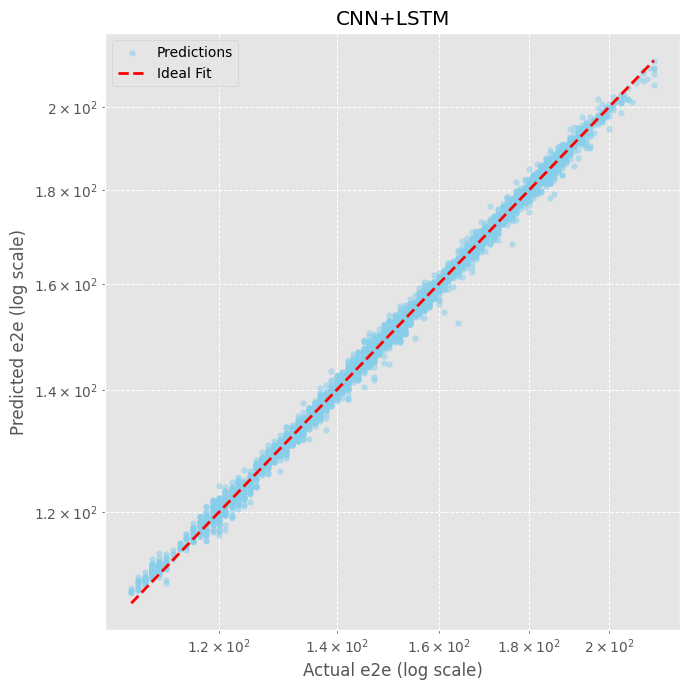

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("CNN+LSTM")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["CNN+LSTM"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.9990
MSE:  1.7343
RMSE: 1.3169
R²:   0.9968


1. Old > MAE:  0.9774, MSE:  1.6663, RMSE: 1.2909, R²:   0.9969
2. New > MAE:  1.3930, MSE:  3.6540, RMSE: 1.9115, R²:   0.9932

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


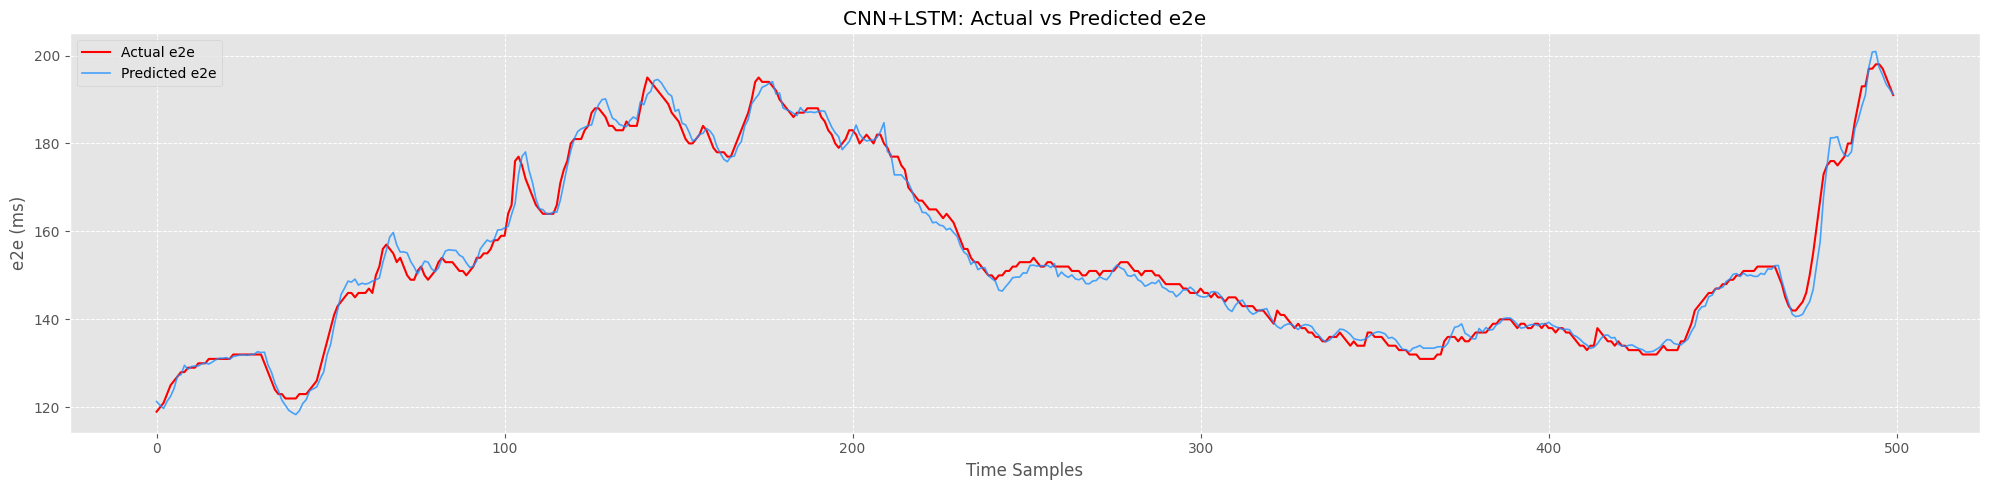

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN+LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


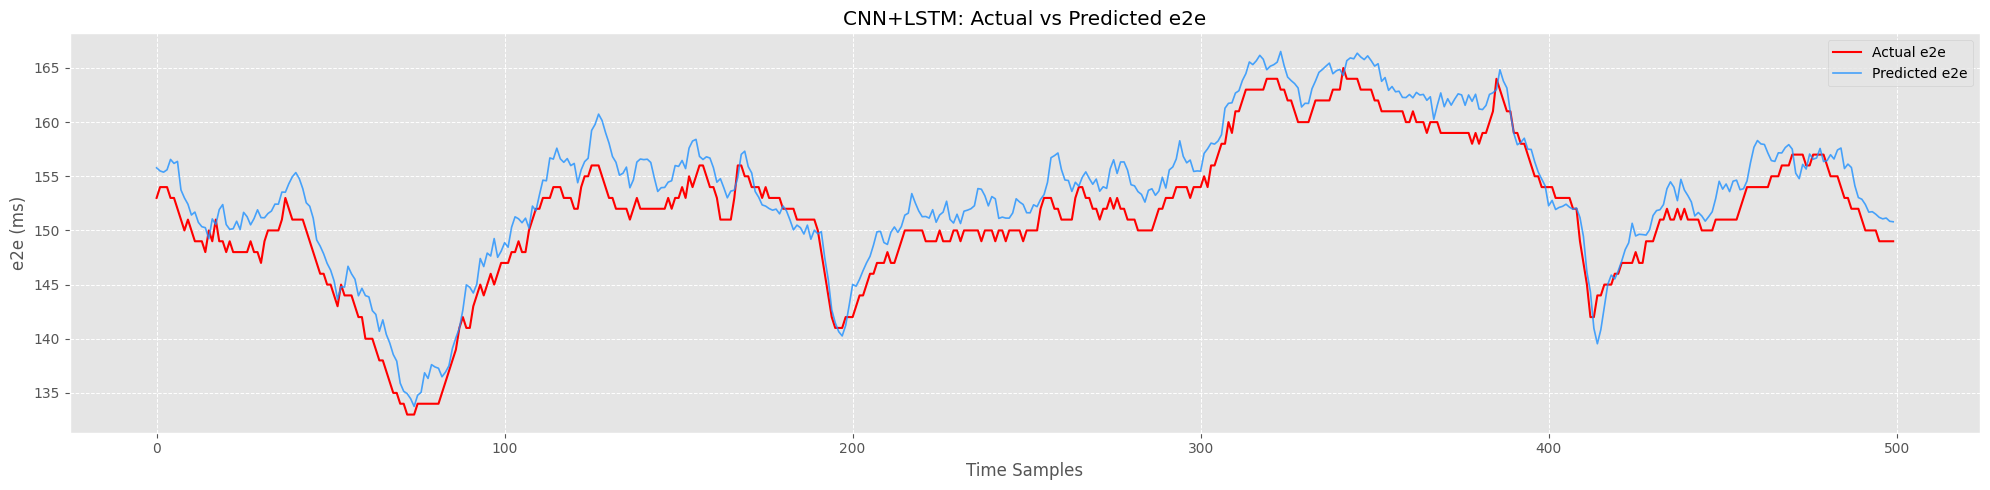

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN+LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


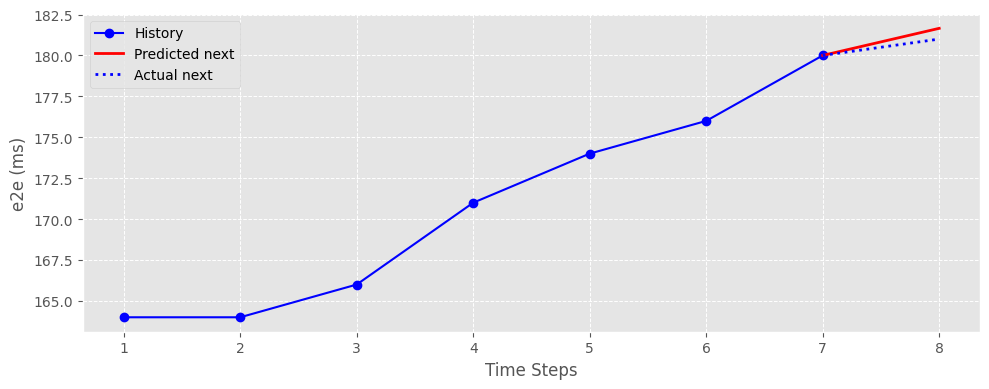

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick an index in your validation set
start_idx = 1120

# Take one input window of shape (1, 5, 40)
X_window = X_val_scaled[start_idx].reshape(1, 5, 40)

# Predict next value
y_pred_scaled = model.predict(X_window)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))[0, 0]

# True next value
y_true = y_scaler.inverse_transform(y_val_scaled[start_idx].reshape(-1, 1))[0, 0]

# For plotting: last 7 values of the target (history)
y_history = y_scaler.inverse_transform(
    y_val_scaled[start_idx-7:start_idx].reshape(-1, 1)
).flatten()

# Plot
plt.figure(figsize=(10, 4))

# History (7 samples)
plt.plot(range(1, 8), y_history, marker="o", color="blue", label="History")

# Predicted next (solid red line from last history point)
plt.plot([7, 8], [y_history[-1], y_pred], "-", color="red", linewidth=2, label="Predicted next")

# Actual next (dotted blue line from last history point)
plt.plot([7, 8], [y_history[-1], y_true], ":", color="blue", linewidth=2, label="Actual next")

plt.xlabel("Time Steps")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#folder_path = "/content/drive/MyDrive/LatencyPrediction/aruco_serial_random"
model.save(folder_path + "/models/cnn_lstm_40f_rand.keras")

In [ ]:
def my_plot(df, to_plot, zoom=slice(None), height=5):
    """
    Plots selected columns of a DataFrame with optional row slicing.

    Parameters:
    - df: pandas DataFrame
    - to_plot: list of column names to plot
    - zoom: slice object or tuple (start, stop), e.g., slice(100, 1000) or (100, 1000)
    """
    if isinstance(zoom, tuple):
        zoom = slice(*zoom)

    fig, ax = plt.subplots(figsize=(20, len(to_plot)*height), nrows=len(to_plot))

    if len(to_plot) == 1:
        ax = [ax]

    for i, col in enumerate(to_plot):
        df[col][zoom].plot(ax=ax[i])
        ax[i].set_xlabel(col, fontsize=20)

    plt.tight_layout()
    plt.show()

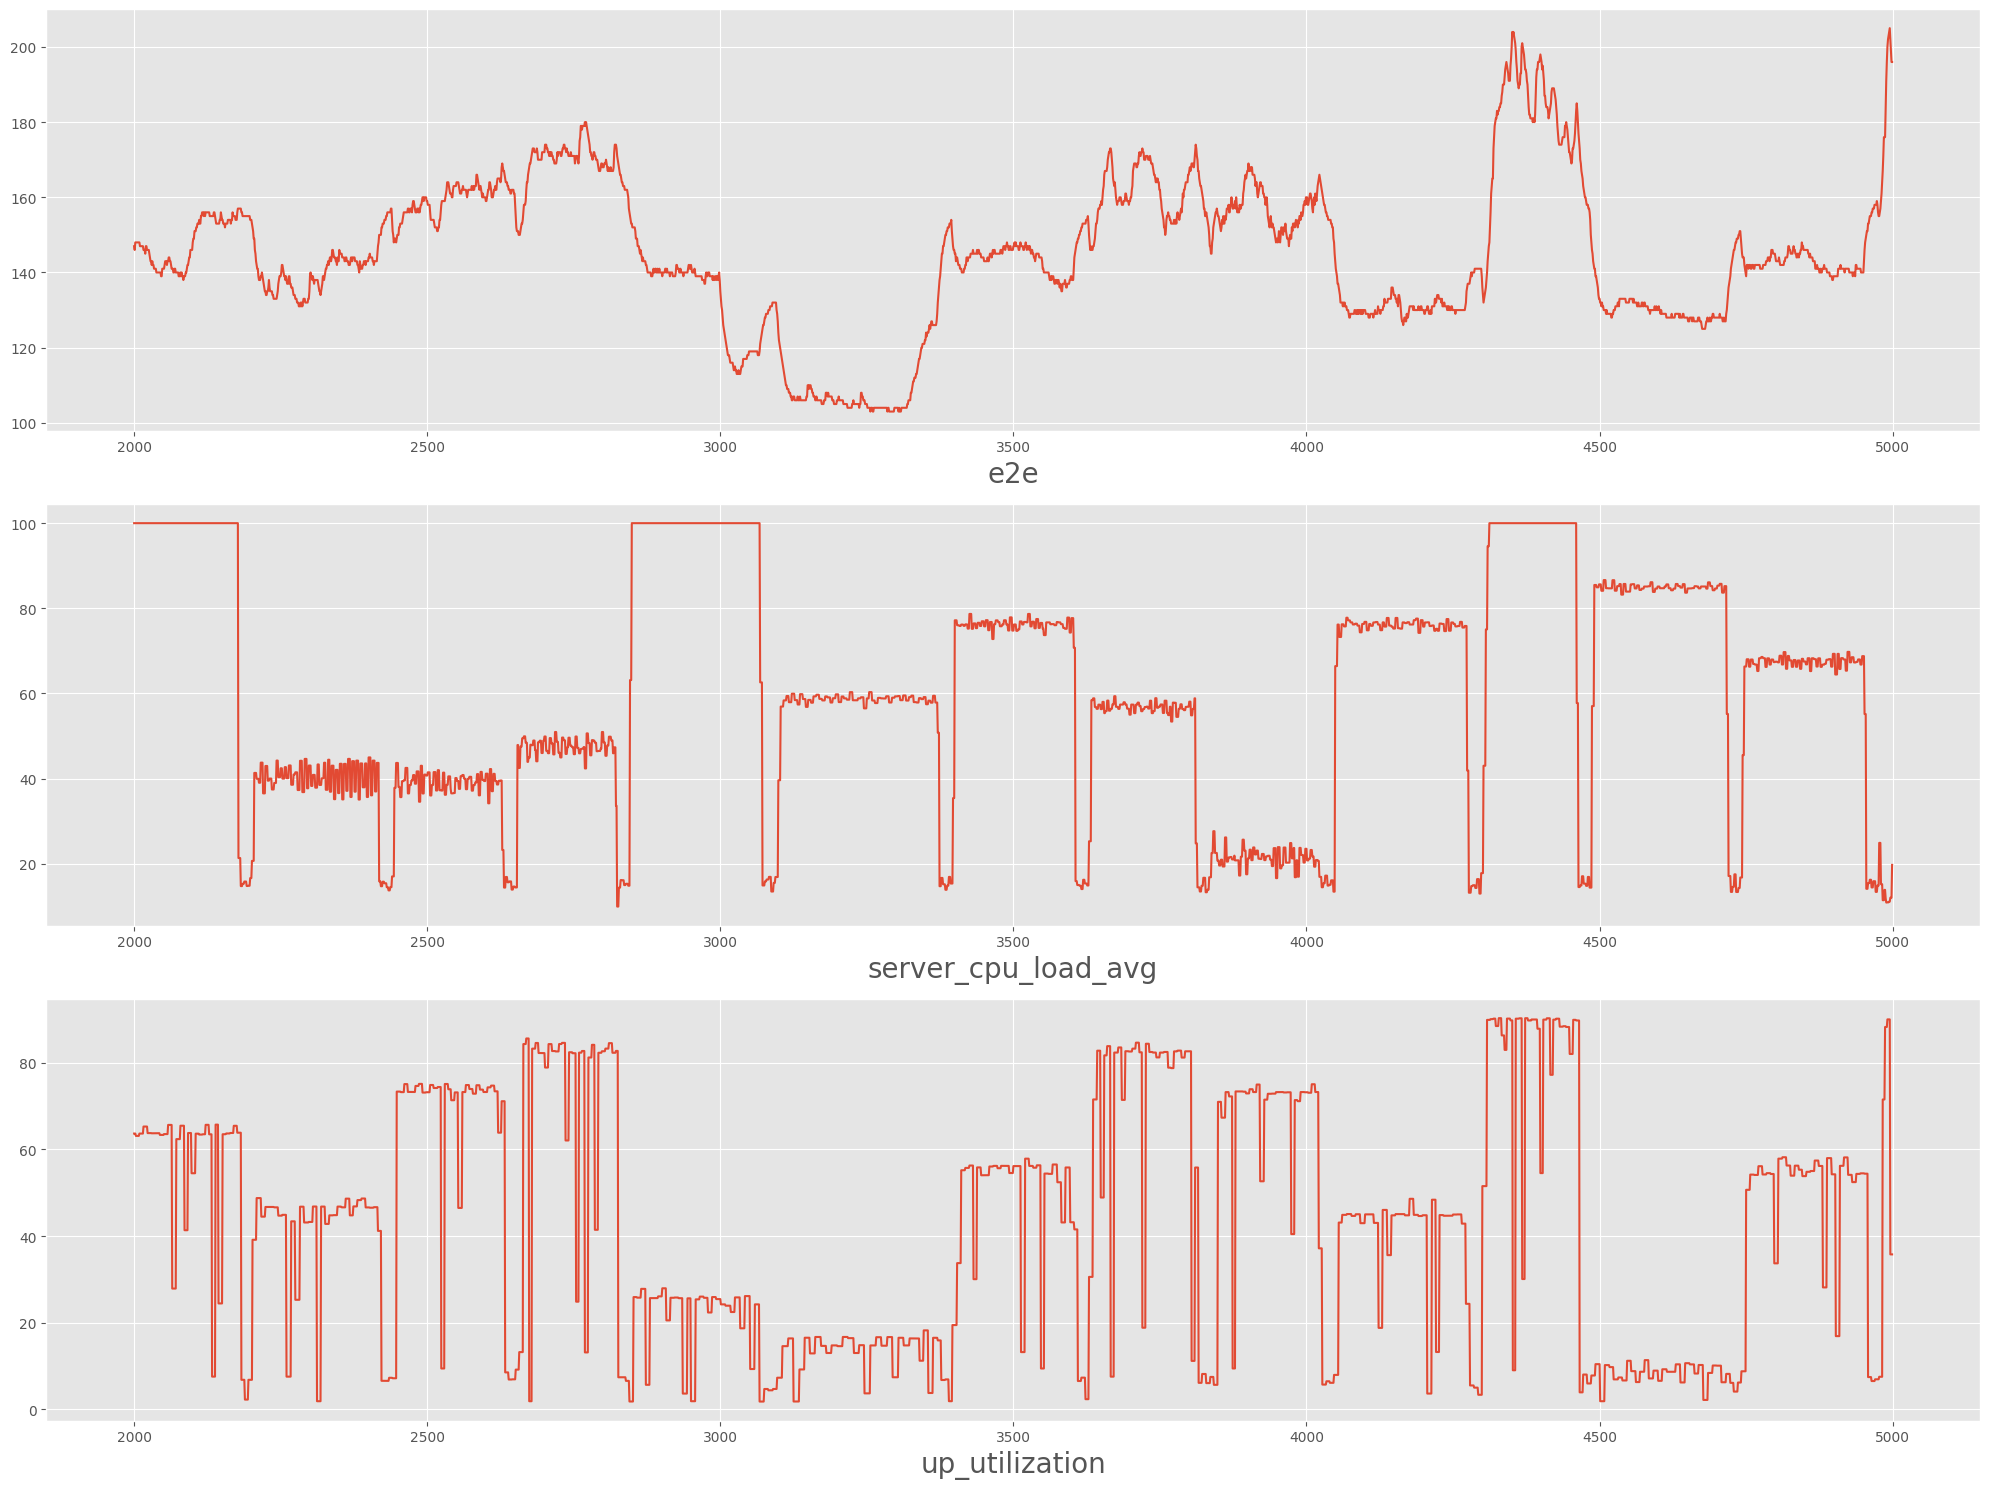

In [ ]:
my_plot(df, ['e2e', 'server_cpu_load_avg', 'up_utilization'], zoom=slice(2000,5000), height=5)

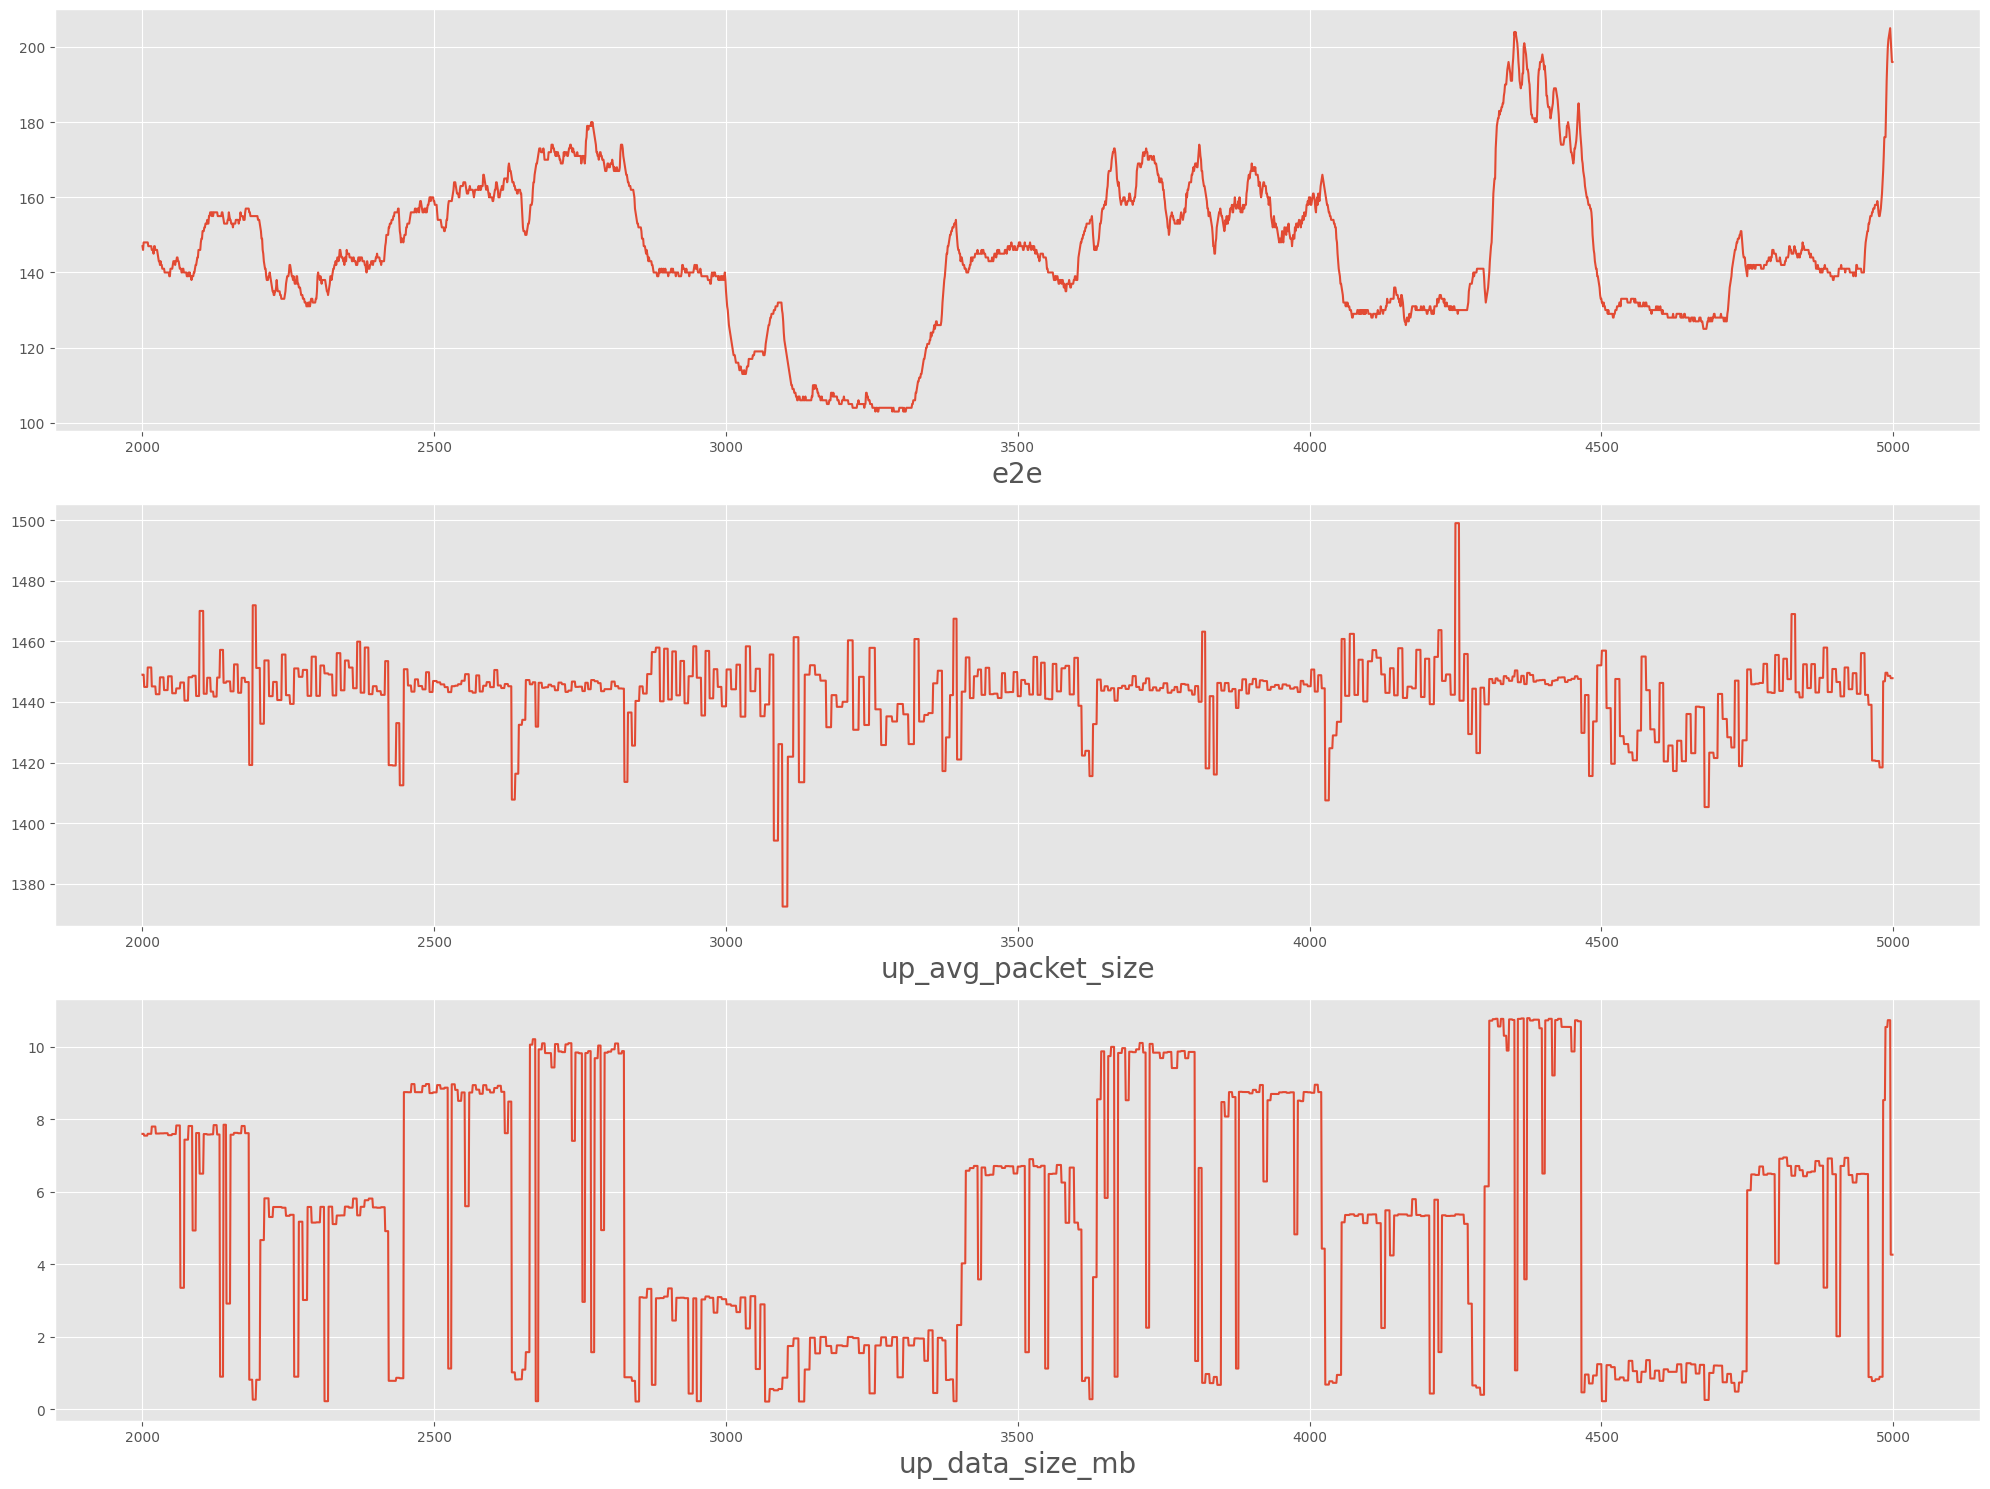

In [ ]:
my_plot(df, ['e2e', 'up_avg_packet_size', 'up_data_size_mb'], zoom=slice(2000,5000), height=5)

In [ ]:
for val in df.columns.values:
    print(val)

e2e
process_data
downlink_trace
video_writing
capture_frame
uplink_trace
server_cpu_load_avg
server_cpu_core1
server_cpu_core2
server_cpu_core3
server_cpu_core4
server_cpu_pre_avg10
server_cpu_pre_avg60
server_cpu-pre_avg300
server_cpu_temp_avg
server_cpu_temp_pkg
server_mem_used
server_upload_mbps
server_download_mbps
client_cpu_load_avg
client_cpu_core1
client_cpu_core2
client_cpu_temp_avg
client_cpu_temp_pkg
client_mem_used
client_upload_mbps
client_download_mbps
up_avg_packet_size
up_data_size_mb
up_avg_packet_rate
up_packet_count
up_throughput
up_utilization
dn_avg_packet_size
dn_data_size_mb
dn_avg_packet_rate
dn_packet_count
dn_throughput
dn_utilization
jitter


# Regression

In [ ]:
def df_to_X_y(df, target_col="e2e"):
    X = df.drop(columns=[target_col]).to_numpy()
    y = df[target_col].to_numpy()
    return X, y

X, y = df_to_X_y(df)
print(X.shape, y.shape)

(27577, 39) (27577,)


In [ ]:
total = len(X)  # should be 27572
split1 = int(total * 0.70)
split2 = split1 + int(total * 0.15)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((19303, 39), (19303,), (4136, 39), (4136,), (4138, 39), (4138,))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_scaled, y_train_scaled)
y_pred = reg.predict(X_test_scaled)

print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)


Coefficients: [ 1.87368536e-01  4.38985573e-01  6.66306376e-02  6.54142221e-02
  1.10198498e-01 -7.79968341e-03  5.81785185e-02 -3.41545227e-02
 -8.20652643e-02  4.10798092e-02 -6.26633017e-03 -1.30821587e-02
 -3.54027708e-02 -5.15338222e-02 -6.17469231e-02 -2.92005713e-02
 -5.52948902e-02 -6.25992802e-02 -1.29155906e-01  1.08391028e-02
 -4.88230072e-02 -4.93599885e-02  6.67699223e-03  2.76326986e-03
 -6.39197436e-02 -6.50636088e-02 -1.49933286e-02  9.93747563e+01
  1.11829616e+02 -1.03777623e+02  3.26710618e+05 -3.26817784e+05
 -2.95732576e-02  2.24885143e+02  2.24570445e+02 -2.25849209e+02
  8.25392362e+04 -8.27629242e+04 -1.55180863e-03]
Intercept: -9.9271861821995e-11


In [ ]:
result_df['linear_reg'] = y_val_pred[:len(result_df)].ravel()

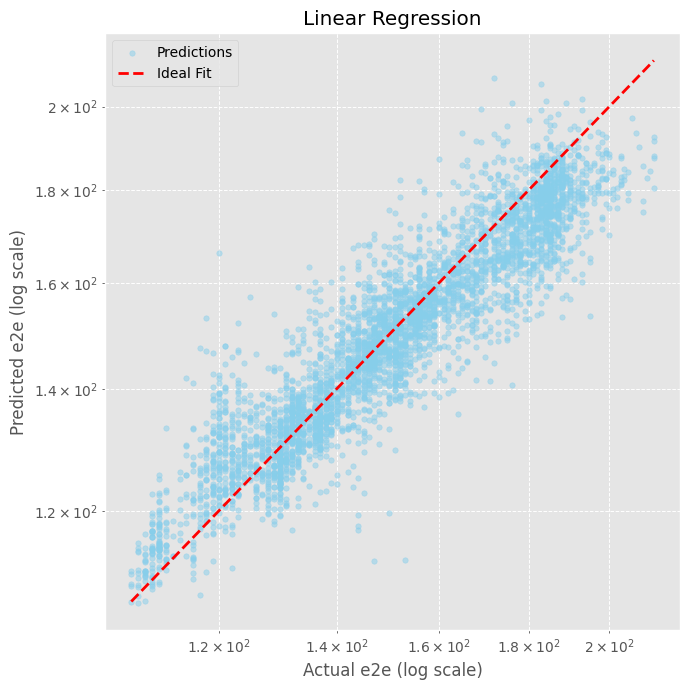

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = reg.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("Linear Regression")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()

fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["LinearReg"] = (fig, ax)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  7.0292
MSE:  87.7936
RMSE: 9.3698
R²:   0.8371


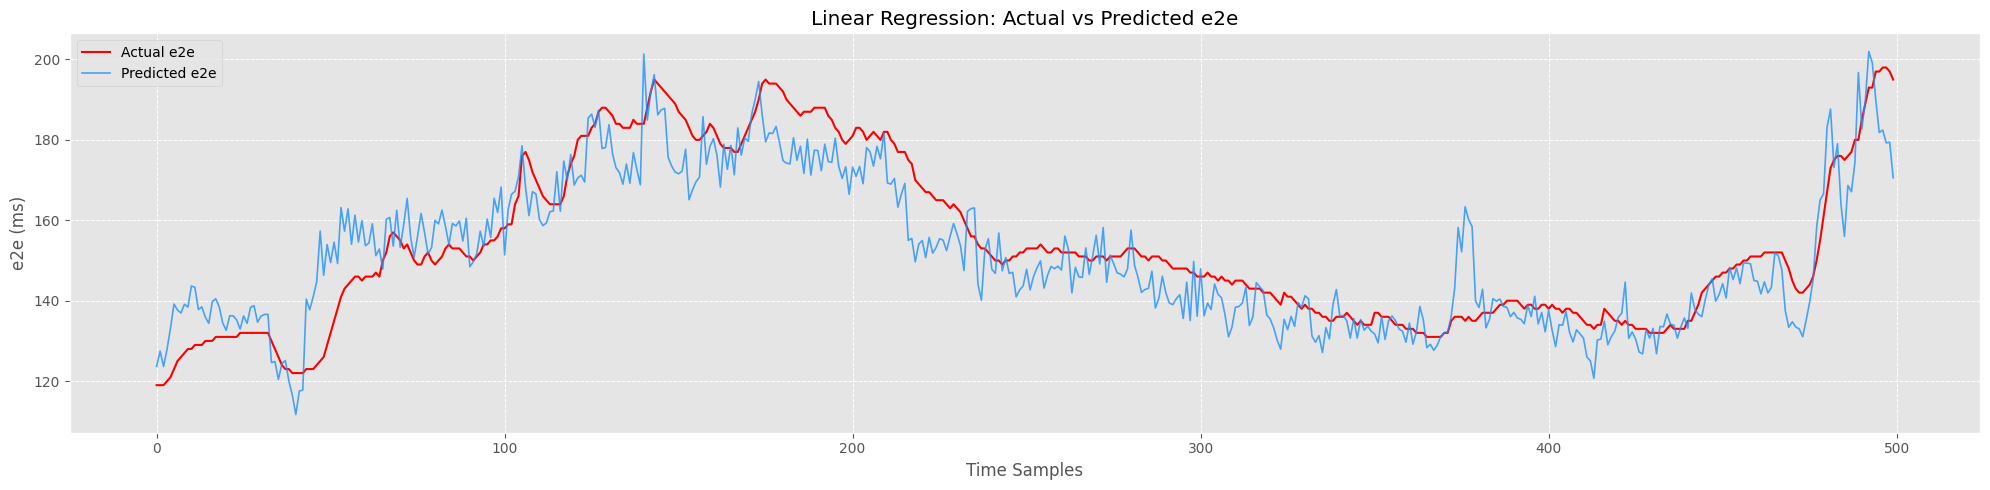

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = reg.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Linear Regression: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Tree Based Models

### Random forrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_scaled)
y_pred = rf.predict(X_val_scaled)

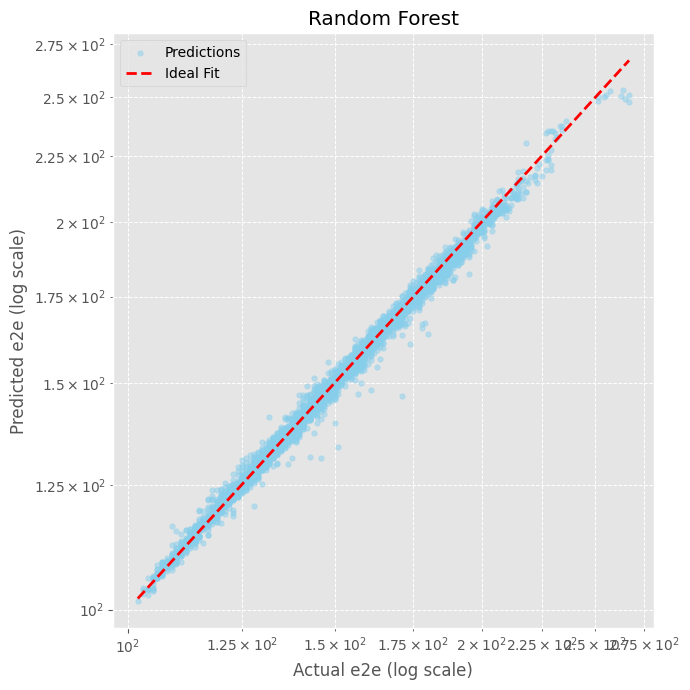

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = rf.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("Random Forest")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["RandForest"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  1.5053
MSE:  4.8274
RMSE: 2.1971
R²:   0.9930


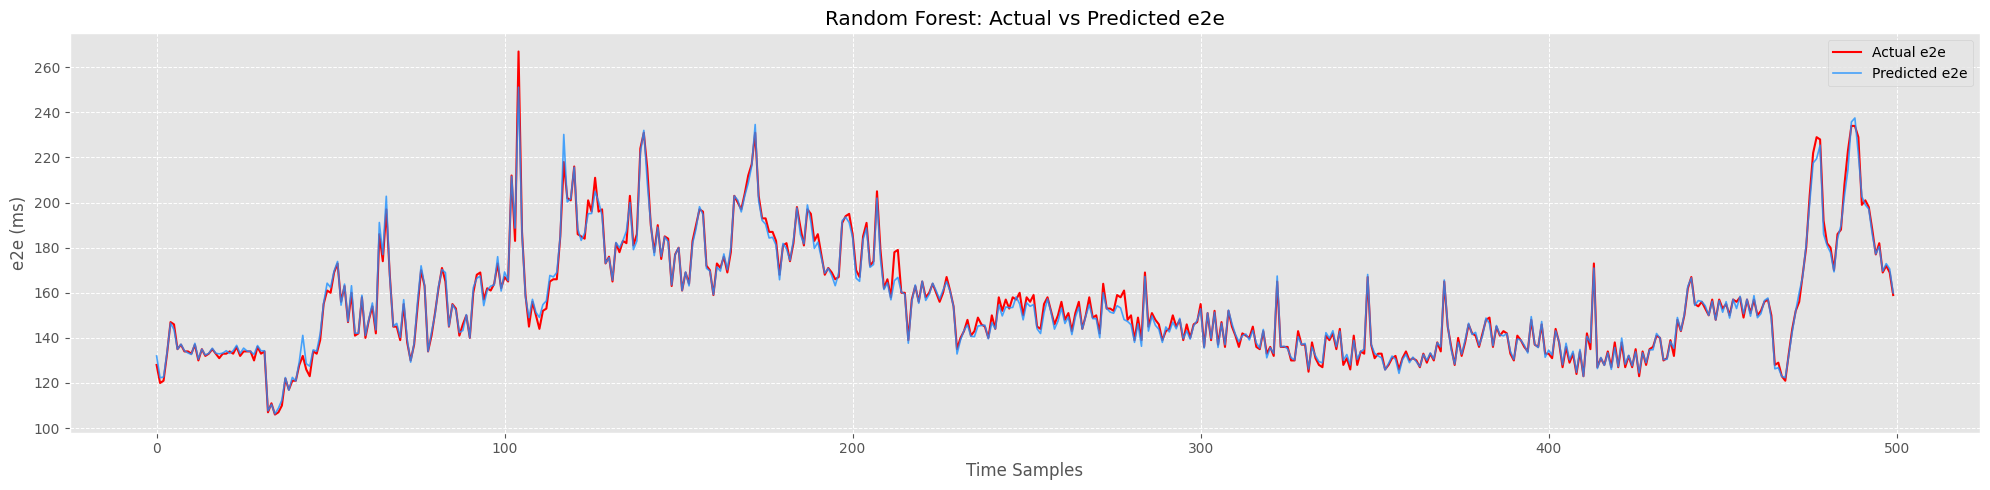

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = rf.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Random Forest: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### Gradient Boosting

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train_scaled)
y_pred = xgb.predict(X_val_scaled)


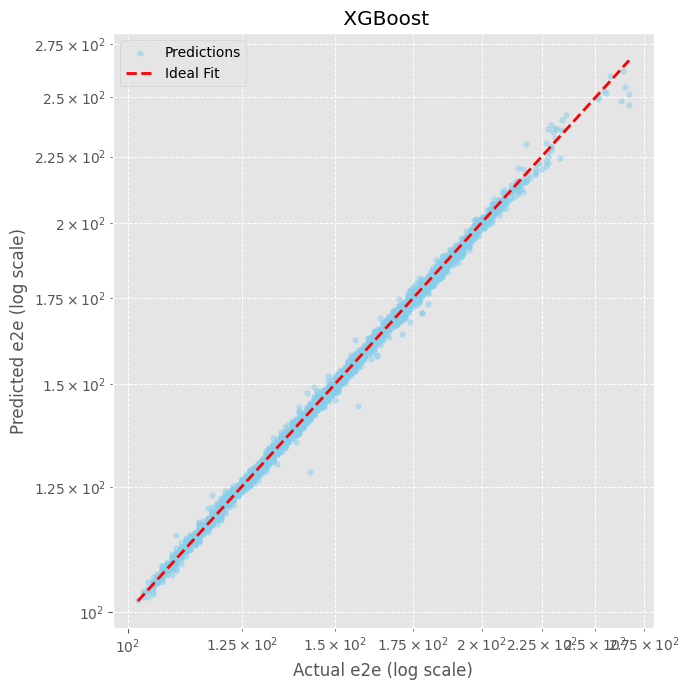

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = xgb.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title(" XGBoost")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["XGBoost"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.9257
MSE:  1.8927
RMSE: 1.3757
R²:   0.9973


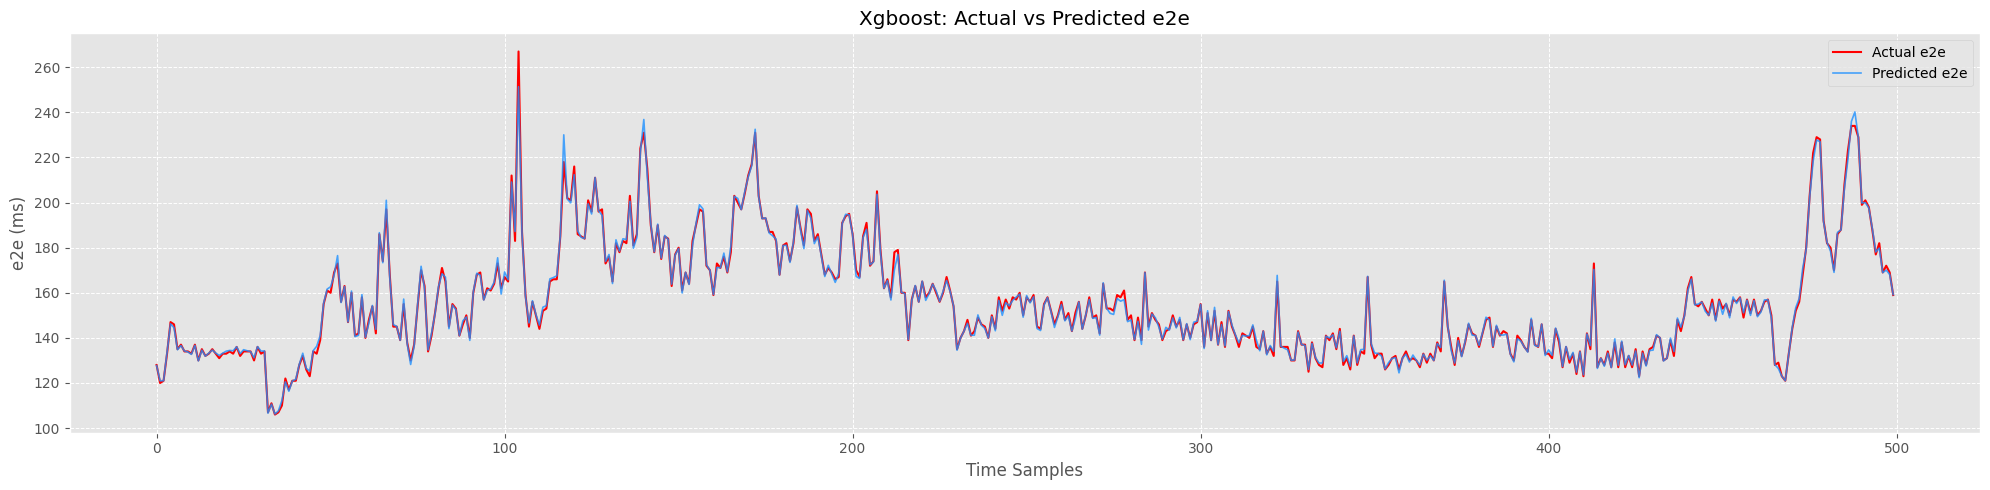

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = xgb.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Xgboost: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Neural Networks (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_scaled)
y_pred = mlp.predict(X_val_scaled)

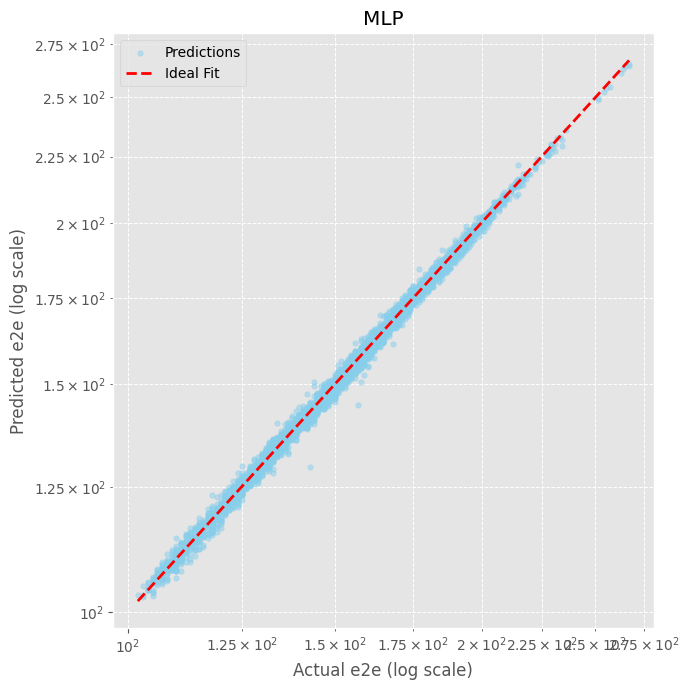

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = mlp.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("MLP")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["MLP"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  1.1902
MSE:  2.3517
RMSE: 1.5335
R²:   0.9966


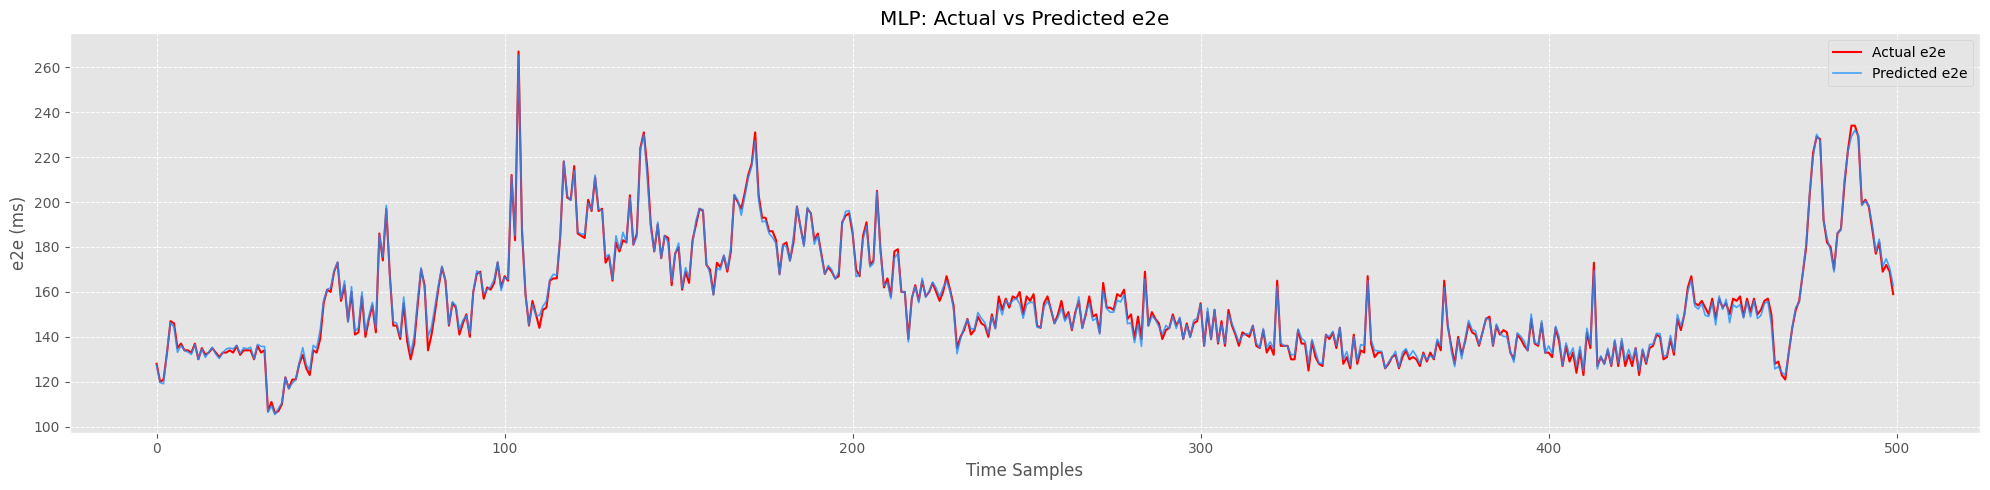

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = mlp.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("MLP: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Arima

Bad for latency prediction. Takes too much time for computation

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import itertools

In [ ]:
ts = df['e2e']
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -9.669885
p-value: 0.000000
Series is stationary; no differencing needed.


In [ ]:
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(y_train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA order: (2, 1, 3) with AIC: 56961.193307262045


Best ARIMA order: (3, 0, 3) with AIC: 81755.46287585859

In [ ]:
final_model = ARIMA(ts, order=(3, 0, 3))
results = final_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_values = results.forecast(steps=10)

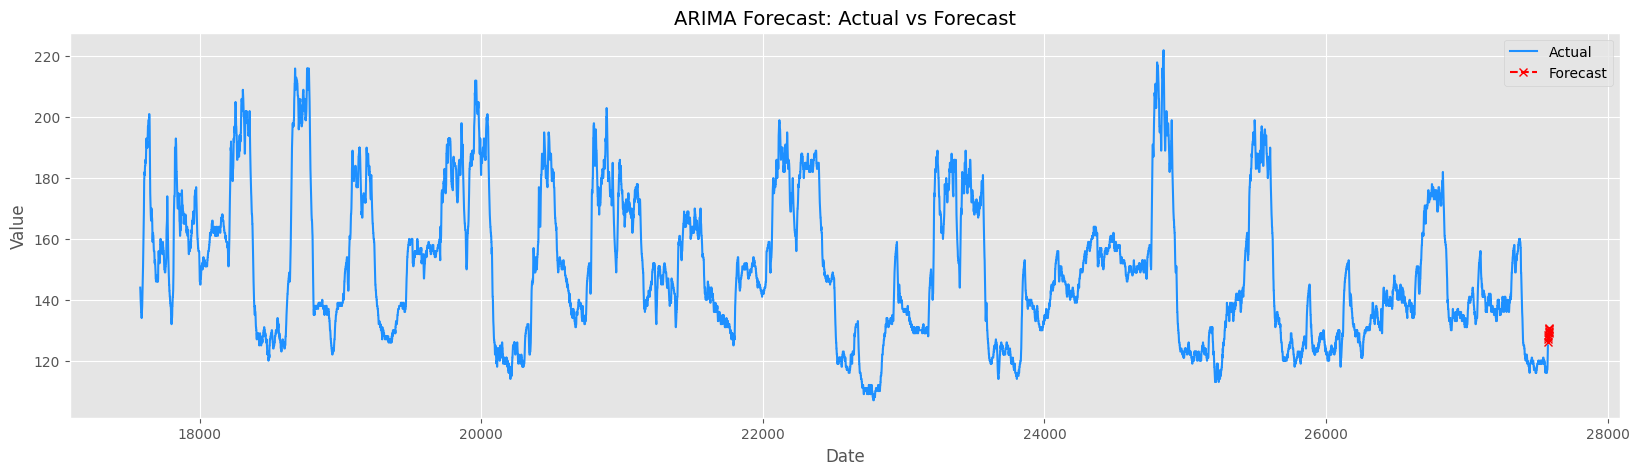

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(ts[-10000:].index, ts[-10000:], label='Actual', color='dodgerblue', linestyle='-')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red', linestyle='--', marker='x')

plt.title('ARIMA Forecast: Actual vs Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Best ARIMA order: (2, 1, 3) with AIC: 56961.193307262045

In [ ]:
final_model = ARIMA(y_train, order=(2, 1, 3))
results = final_model.fit()

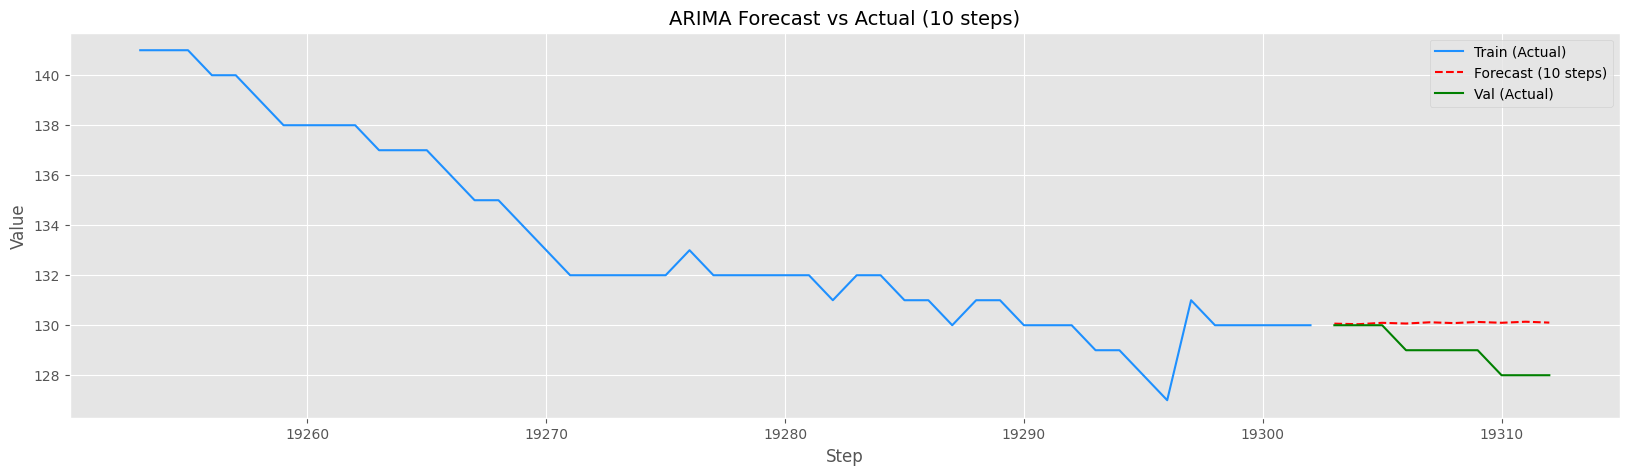

In [ ]:
plt.figure(figsize=(20, 5))

to_forecast = 10
forecast_values = results.forecast(steps=to_forecast)

tail = 50
n_train = len(y_train)
start = max(0, n_train - tail)

x_train = range(start, n_train)
y_train_tail = y_train[start:]

y_val_crop = y_val[:to_forecast]
x_forecast = range(n_train, n_train + len(forecast_values))
x_val      = range(n_train, n_train + len(y_val_crop))

plt.plot(x_train, y_train_tail,
         label='Train (Actual)', color='dodgerblue', linestyle='-')

plt.plot(x_forecast, getattr(forecast_values, "values", forecast_values),
         label=f'Forecast ({to_forecast} steps)', color='red', linestyle='--')

plt.plot(x_val, y_val_crop,
         label='Val (Actual)', color='green', linestyle='-')

plt.title(f'ARIMA Forecast vs Actual ({to_forecast} steps)', fontsize=14)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
y_train.shape, y_test.shape, y_val.shape

((19303,), (4138,), (4136,))

# Comparision

In [ ]:
from tabulate import tabulate

def add_metrics(label: str, metrics_str: str):
    metrics = {}
    for line in metrics_str.strip().splitlines():
        if ":" in line:
            key, val = line.split(":")
            metrics[key.strip()] = float(val.strip())
    results[label] = metrics

results = {}

In [ ]:
add_metrics("Linear Reg",
"""
MAE:  7.0292
MSE:  87.7936
RMSE: 9.3698
R²:   0.8371
""")

add_metrics("Rand Forrest",
"""
MAE:  6.5824
MSE:  74.1065
RMSE: 8.6085
R²:   0.8625
""")

add_metrics("XGboost",
"""
MAE:  5.9926
MSE:  62.2512
RMSE: 7.8899
R²:   0.8845
""")

add_metrics("MLP",
"""
MAE:  7.4515
MSE:  96.0256
RMSE: 9.7993
R²:   0.8218
""")

add_metrics("CNN",
"""
MAE:  0.7970
MSE:  1.2314
RMSE: 1.1097
R²:   0.9977
""")

add_metrics("GRU",
"""
MAE:  0.9606
MSE:  1.6668
RMSE: 1.2910
R²:   0.9969
""")

add_metrics("LSTM",
"""
MAE:  1.0229
MSE:  1.8304
RMSE: 1.3529
R²:   0.9966
""")

add_metrics("CNN+LSTM",
"""
MAE:  0.9774
MSE:  1.6663
RMSE: 1.2909
R²:   0.9969
""")


In [ ]:
headers = ["Model"] + list(next(iter(results.values())).keys())
table = [[label] + [metrics[k] for k in headers[1:]] for label, metrics in results.items()]

print(tabulate(table, headers=headers, floatfmt=".4f"))

Model            MAE      MSE    RMSE      R²
------------  ------  -------  ------  ------
Linear Reg    7.0292  87.7936  9.3698  0.8371
Rand Forrest  6.5824  74.1065  8.6085  0.8625
XGboost       5.9926  62.2512  7.8899  0.8845
MLP           7.4515  96.0256  9.7993  0.8218
CNN           0.7970   1.2314  1.1097  0.9977
GRU           0.9606   1.6668  1.2910  0.9969
LSTM          1.0229   1.8304  1.3529  0.9966
CNN+LSTM      0.9774   1.6663  1.2909  0.9969


In [ ]:
print(plots.keys())

dict_keys(['LinearReg', 'RandForest', 'XGBoost', 'MLP', 'CNN', 'GRU', 'LSTM', 'CNN+LSTM'])


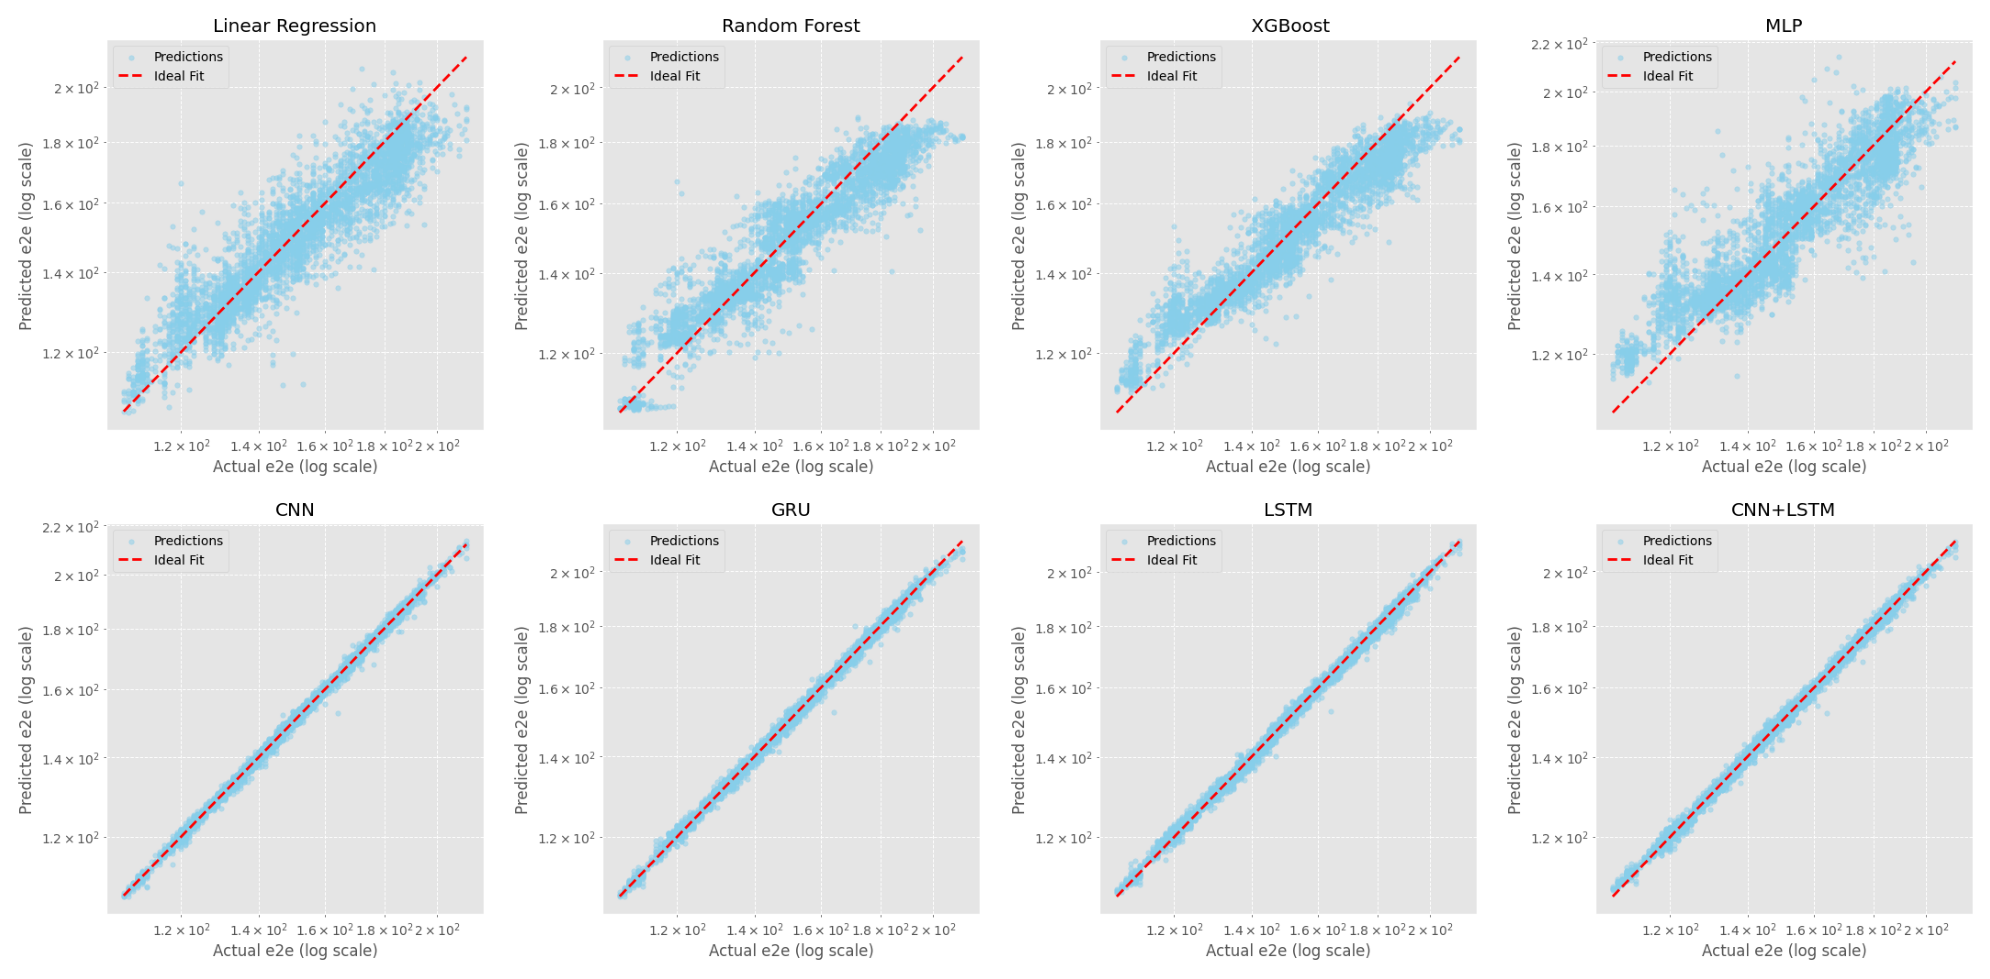

In [ ]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Order you want
labels = ['LinearReg', 'RandForest', 'XGBoost', 'MLP',
          'CNN', 'GRU', 'LSTM', 'CNN+LSTM']

# Make a 2 x 4 grid (each cell ~5x5 inches -> overall 20x10)
grid_fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, label in enumerate(labels):
    fig, ax = plots[label]

    # resize each source fig to 5x5 inches
    fig.set_size_inches(5, 5)

    # render source fig to a PNG in-memory
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100, bbox_inches="tight")
    buf.seek(0)

    # read back as image and show in target subplot
    img = Image.open(buf)
    axes[i].imshow(img)
    #axes[i].set_title(label)
    axes[i].axis('off')  # hide axes for clean look

plt.tight_layout()
plt.show()


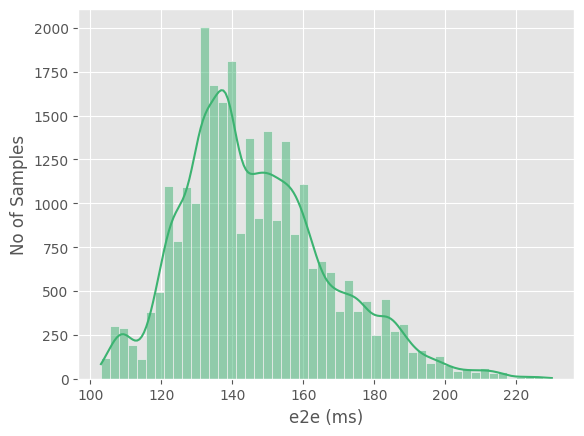

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['e2e'], kde=True, bins=50, color='mediumseagreen')
#plt.title('Distribution of e2e')
plt.xlabel('e2e (ms)')
plt.ylabel('No of Samples')
plt.grid(True)
plt.show()

In [ ]:
df['e2e'].describe()

count    27577.000000
mean       146.714291
std         20.722200
min        103.000000
25%        132.000000
50%        144.000000
75%        159.000000
max        230.000000
Name: e2e, dtype: float64

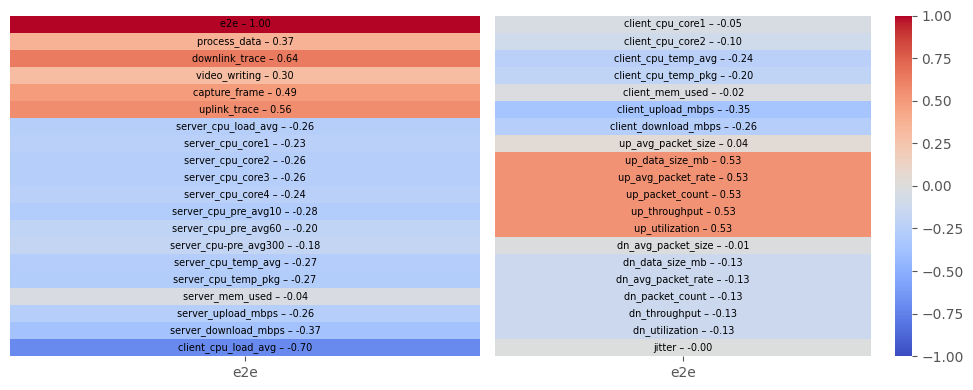

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr_mat = df.corr()[['e2e']]

mid = len(corr_mat) // 2
corr1 = corr_mat.iloc[:mid]
corr2 = corr_mat.iloc[mid:]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# First heatmap
sns.heatmap(
    corr1, cmap='coolwarm', ax=axes[0],
    cbar=False, center=0, vmin=-1, vmax=1,
    yticklabels=False, annot=False
)

for y, (feat, val) in enumerate(corr1['e2e'].items()):
    axes[0].text(
        0.5, y + 0.5,
        f"{feat} – {val:.2f}",
        ha='center', va='center',
        fontsize=7, color='black'
    )

# Second heatmap
sns.heatmap(
    corr2, cmap='coolwarm', ax=axes[1],
    cbar=True, center=0, vmin=-1, vmax=1,
    yticklabels=False, annot=False
)

for y, (feat, val) in enumerate(corr2['e2e'].items()):
    axes[1].text(
        0.5, y + 0.5,
        f"{feat} – {val:.2f}",
        ha='center', va='center',
        fontsize=7, color='black'
    )

plt.tight_layout()
plt.show()


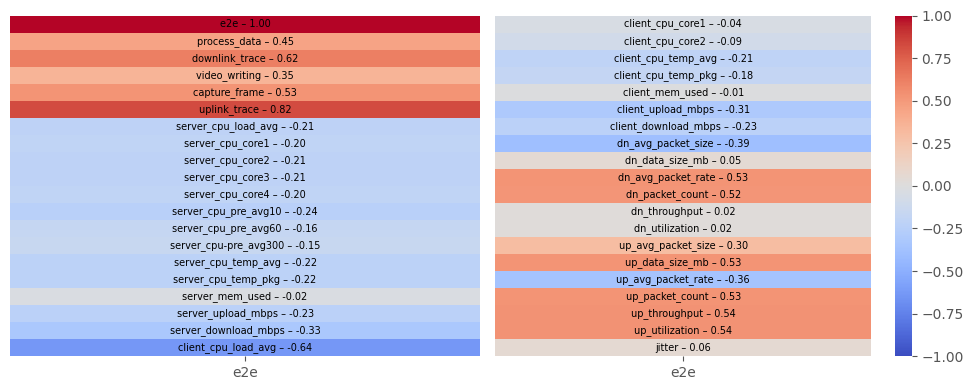

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr_mat = df.corr()[['e2e']]

mid = len(corr_mat) // 2
corr1 = corr_mat.iloc[:mid]
corr2 = corr_mat.iloc[mid:]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# First heatmap
sns.heatmap(
    corr1, cmap='coolwarm', ax=axes[0],
    cbar=False, center=0, vmin=-1, vmax=1,
    yticklabels=False, annot=False
)

for y, (feat, val) in enumerate(corr1['e2e'].items()):
    axes[0].text(
        0.5, y + 0.5,
        f"{feat} – {val:.2f}",
        ha='center', va='center',
        fontsize=7, color='black'
    )

# Second heatmap
sns.heatmap(
    corr2, cmap='coolwarm', ax=axes[1],
    cbar=True, center=0, vmin=-1, vmax=1,
    yticklabels=False, annot=False
)

for y, (feat, val) in enumerate(corr2['e2e'].items()):
    axes[1].text(
        0.5, y + 0.5,
        f"{feat} – {val:.2f}",
        ha='center', va='center',
        fontsize=7, color='black'
    )

plt.tight_layout()
plt.show()

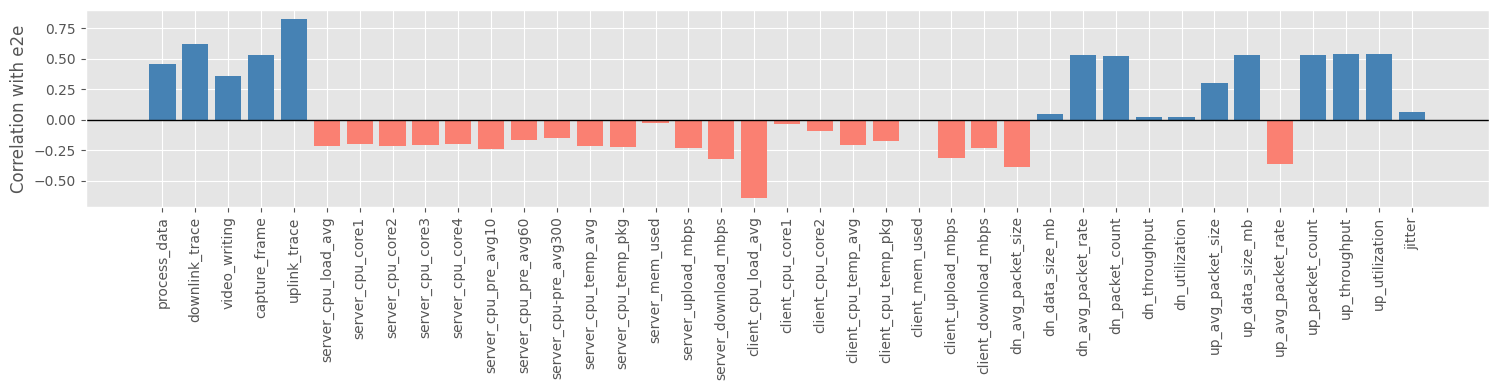

In [ ]:
import matplotlib.pyplot as plt

# Get correlation with e2e as a Series instead of a DataFrame
corr_with_e2e = df.corr()['e2e'].drop('e2e')  # drop self-correlation

# Colors based on sign
colors = ["steelblue" if v > 0 else "salmon" for v in corr_with_e2e]

plt.figure(figsize=(15, 4))
plt.bar(corr_with_e2e.index, corr_with_e2e.values, color=colors)
plt.axhline(0, color="black", linewidth=1)  # zero reference line

plt.xticks(rotation=90)
plt.ylabel("Correlation with E2E")
#plt.title("Feature Correlations with e2e (Positive vs Negative)")
plt.tight_layout()
plt.show()



In [ ]:
def my_plot(df, to_plot, zoom=slice(None), height=5):
    """
    Plots selected columns of a DataFrame with optional row slicing.

    Parameters:
    - df: pandas DataFrame
    - to_plot: list of column names to plot
    - zoom: slice object or tuple (start, stop), e.g., slice(100, 1000) or (100, 1000)
    """
    if isinstance(zoom, tuple):
        zoom = slice(*zoom)

    fig, ax = plt.subplots(figsize=(20, len(to_plot)*height), nrows=len(to_plot))

    if len(to_plot) == 1:
        ax = [ax]

    for i, col in enumerate(to_plot):
        df[col][zoom].plot(ax=ax[i])
        ax[i].set_xlabel(col, fontsize=14)

    plt.tight_layout()
    plt.show()

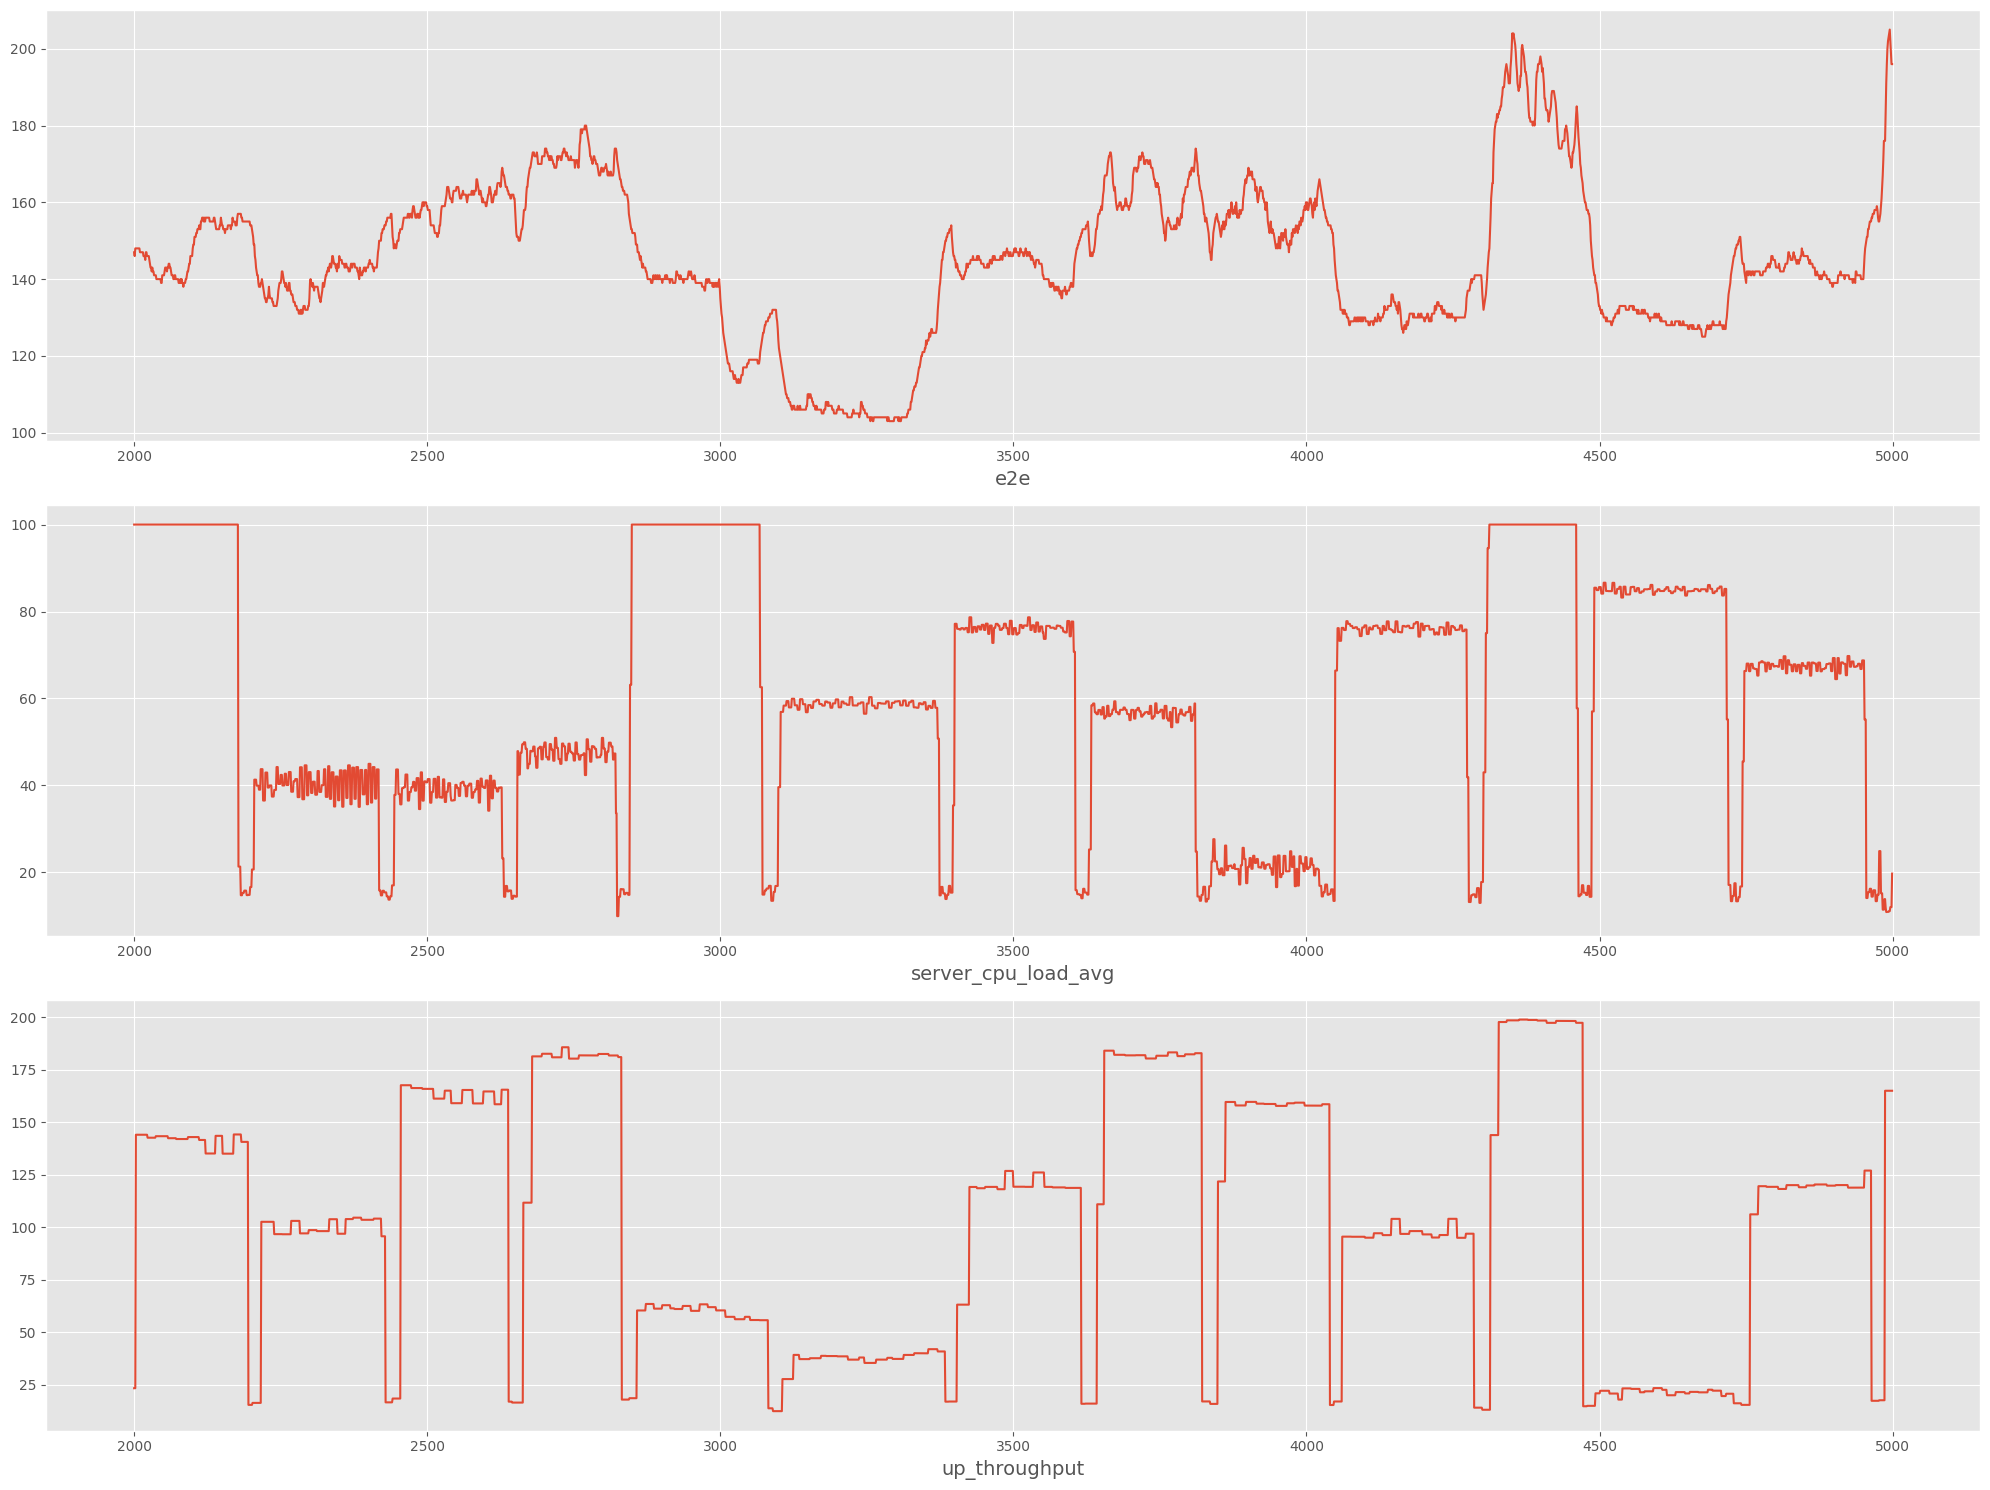

In [ ]:
my_plot(df, ['e2e', 'server_cpu_load_avg', 'up_throughput'], zoom=slice(2000,5000), height=5)

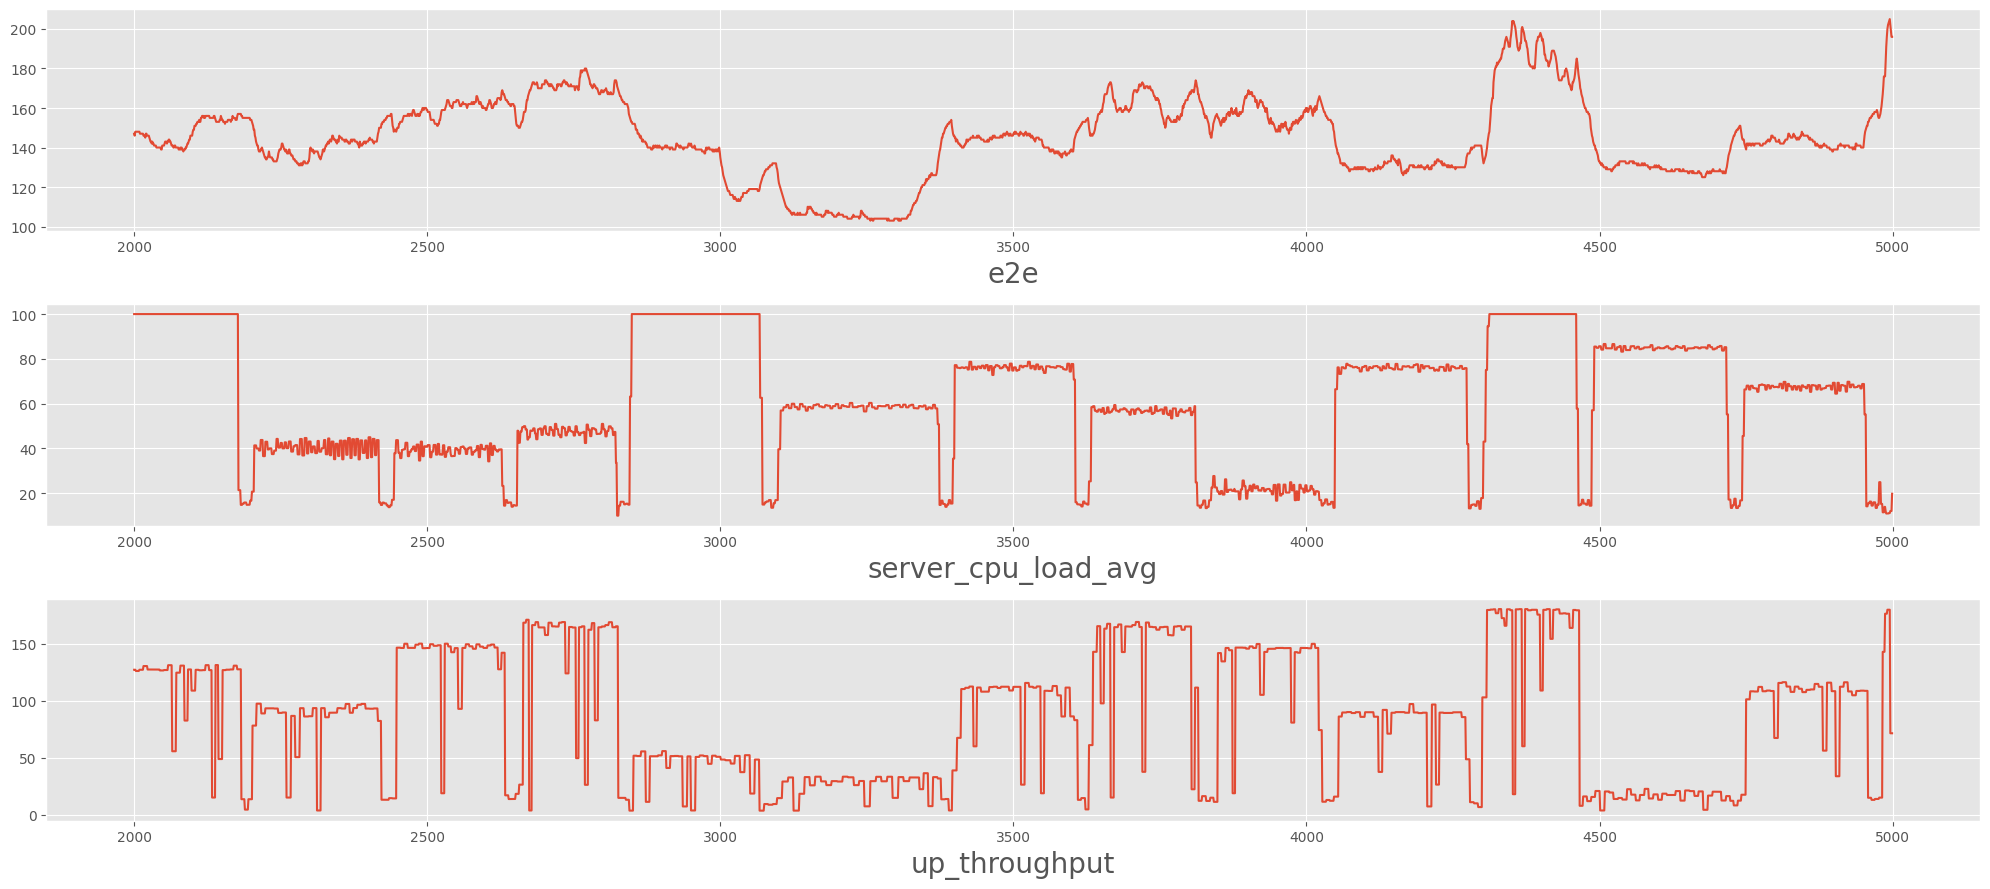

In [ ]:
my_plot(df, ['e2e', 'server_cpu_load_avg', 'up_throughput'], zoom=slice(2000,5000), height=3)

In [ ]:
#graph
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np



cnn_model = keras.models.load_model(folder_path + "/models/cnn_40f_rand.keras")
gru_model = keras.models.load_model(folder_path + "/models/gru_40f_rand.keras")
lstm_model = keras.models.load_model(folder_path + "/models/lstm_40f_rand.keras")
cnn_lstm_model = keras.models.load_model(folder_path + "/models/cnn_lstm_40f_rand.keras")

y_pred_cnn = cnn_model.predict(X_val_scaled)
y_pred_gru = gru_model.predict(X_val_scaled)
y_pred_lstm = lstm_model.predict(X_val_scaled)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_val_scaled)

cnn_inv = y_scaler.inverse_transform(y_pred_cnn).ravel()
gru_inv = y_scaler.inverse_transform(y_pred_gru).ravel()
lstm_inv = y_scaler.inverse_transform(y_pred_lstm).ravel()
cnn_lstm_inv = y_scaler.inverse_transform(y_pred_cnn_lstm).ravel()

result_df = pd.DataFrame({
    "cnn_pred": cnn_inv,
    "gru_pred": gru_inv,
    "lstm_pred": lstm_inv,
    "cnn_lstm_pred": cnn_lstm_inv,
})


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
validation_df = df.iloc[split1:split2].copy()

if result_df.shape[0] == validation_df.shape[0]:
    # join side by side
    prediction_df = validation_df.copy()
    for col in result_df.columns:
        prediction_df[col] = result_df[col].values
else:
    print("Size mismatch")
    prediction_df = validation_df.copy()

prediction_df = prediction_df.reset_index(drop=True)
prediction_df

e2e  process_data  downlink_trace  video_writing  capture_frame  \
0     130            36            16.0           33.0           29.0   
1     130            32            16.0           34.0           31.0   
2     130            34            17.0           31.0           29.0   
3     130            33            16.0           32.0           30.0   
4     130            35            16.0           33.0           30.0   
...   ...           ...             ...            ...            ...   
4130  176            33            18.0           32.0           32.0   
4131  178            34            17.0           35.0           32.0   
4132  178            32            18.0           32.0           31.0   
4133  185            30            16.0           35.0           32.0   
4134  185            29            15.0           29.0           32.0   

      uplink_trace  server_cpu_load_avg  server_cpu_core1  server_cpu_core2  \
0               21            93.112229         92.128262         92.128262   
1               15            93.112229         92.128262         92.128262   
2               15            93.112229         92.128262         92.128262   
3               14            93.112229         92.128262         92.128262   
4               18            93.090779         92.103747         94.077810   
...            ...                  ...               ...               ...   
4130            72            84.292952         84.292952         84.292952   
4131            81            84.292952         84.292952         84.292952   
4132            72            83.243979         84.229628         84.229628   
4133           139            83.243979         84.229628         84.229628   
4134            77            83.710958         84.204565         82.230136   

      server_cpu_core3  server_cpu_core4  server_cpu_pre_avg10  \
0            94.096197         94.096197                  5.32   
1            94.096197         94.096197                  5.32   
2            94.096197         94.096197                  5.32   
3            94.096197         94.096197                  5.32   
4            92.103747         94.077810                  5.80   
...                ...               ...                   ...   
4130         82.329571         86.256333                  4.33   
4131         82.329571         86.256333                  4.33   
4132         84.229628         80.287035                  4.63   
4133         84.229628         80.287035                  4.63   
4134         88.153424         80.255706                  4.63   

      server_cpu_pre_avg60  server_cpu-pre_avg300  server_cpu_temp_avg  \
0                     4.28                   2.88                75.00   
1                     4.28                   2.88                75.00   
2                     4.28                   2.88                75.00   
3                     4.28                   2.88                75.00   
4                     4.40                   2.92                75.00   
...                    ...                    ...                  ...   
4130                  4.21                   3.34                74.25   
4131                  4.21                   3.34                74.25   
4132                  4.27                   3.36                74.25   
4133                  4.27                   3.36                74.25   
4134                  4.27                   3.36                73.00   

      server_cpu_temp_pkg  server_mem_used  server_upload_mbps  \
0                    77.0           14.270             9.51833   
1                    77.0           14.270             9.51833   
2                    77.0           14.270             9.51833   
3                    77.0           14.270             9.51833   
4                    77.0           14.274            10.42743   
...                   ...              ...                 ...   
4130                 77.0           

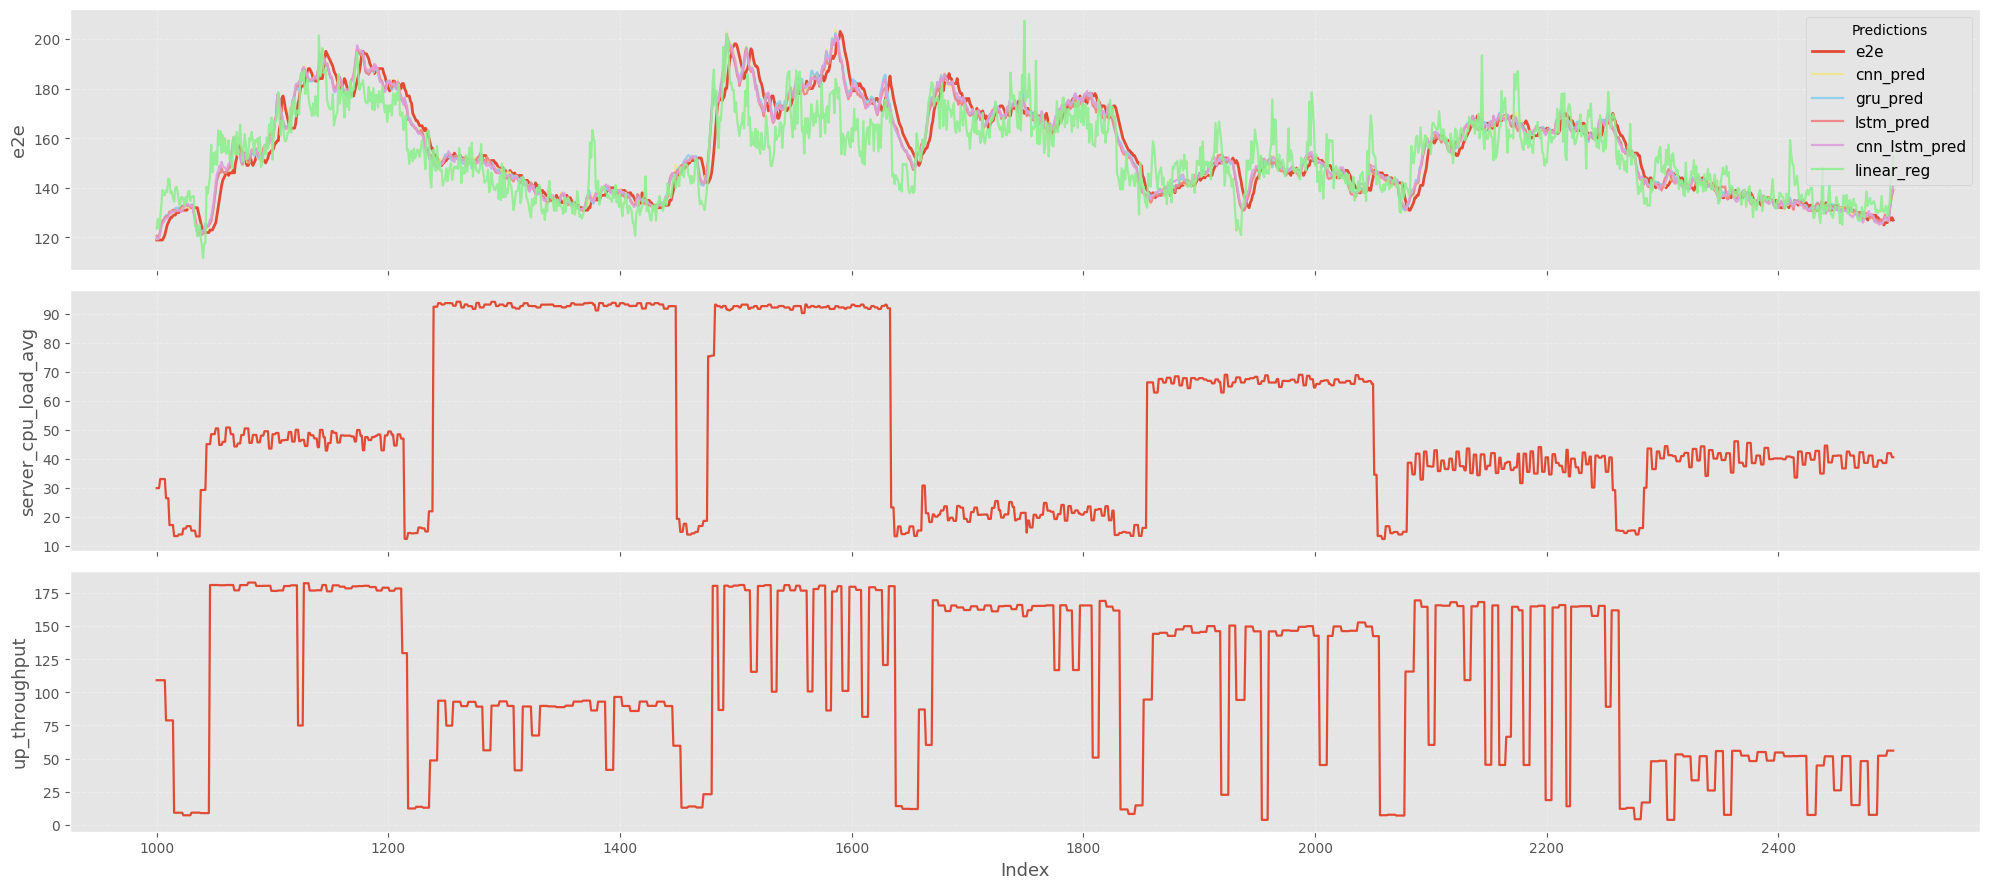

In [ ]:
def my_plot2(
    df,
    to_plot,
    zoom=slice(None),
    height=5,
    true_col="e2e",
    pred_cols=None,
    pred_colors=None,
    true_kwargs=None,
    pred_kwargs=None,
):

    import matplotlib.pyplot as plt

    if isinstance(zoom, tuple):
        zoom = slice(*zoom)

    # Auto-detect prediction columns if not provided
    if pred_cols is None:
        pred_cols = [c for c in df.columns if c.endswith("_pred")]

    # Default styles
    if true_kwargs is None:
        true_kwargs = {"linewidth": 2.5}
    if pred_kwargs is None:
        pred_kwargs = {"linewidth": 1.6, "alpha": 0.9}

    # Basic validation
    missing = [c for c in to_plot if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in df: {missing}")

    # Setup figure/axes
    nrows = len(to_plot)
    fig, ax = plt.subplots(figsize=(20, nrows * height), nrows=nrows, sharex=True)
    if nrows == 1:
        ax = [ax]

    # Plot each requested column
    for i, col in enumerate(to_plot):
        # Standard plot for each column
        df[col][zoom].plot(ax=ax[i], **({"linewidth": 1.6} if col != true_col else true_kwargs))
        ax[i].set_ylabel(col, fontsize=13)
        ax[i].grid(True, linestyle="--", alpha=0.3)

        # If this is the first subplot for the true series, overlay predictions
        if i == 0 and col == true_col and pred_cols:
            # Make sure we only plot preds that exist in df
            plot_preds = [c for c in pred_cols if c in df.columns]
            if not plot_preds:
                continue

            # Handle colors
            if pred_colors is None:
                # Let matplotlib cycle default colors
                color_list = [None] * len(plot_preds)
            else:
                if len(pred_colors) != len(plot_preds):
                    raise ValueError("Length of pred_colors must match pred_cols.")
                color_list = pred_colors

            for pcol, c in zip(plot_preds, color_list):
                df[pcol][zoom].plot(ax=ax[i], label=pcol, color=c, **pred_kwargs)

            # Build legend (include true + preds)
            handles, labels = ax[i].get_legend_handles_labels()
            # If there is no explicit label for the true line yet, add one
            if true_kwargs is not None:
                handles = [handles[0]] + handles[1:]
            ax[i].legend(loc="best", fontsize=11, title="Predictions")

        # Cosmetic x label only on bottom plot
        if i == nrows - 1:
            ax[i].set_xlabel("Index", fontsize=13)
        else:
            ax[i].set_xlabel("")

    plt.tight_layout()
    plt.show()

my_plot2(
    prediction_df,
    to_plot=['e2e', 'server_cpu_load_avg', 'up_throughput'],
    zoom=slice(1000,2500),
    height=3,
    true_col='e2e',
    pred_cols=['cnn_pred', 'gru_pred', 'lstm_pred', 'cnn_lstm_pred', 'linear_reg'],
    # Optional explicit colors if you want them fixed:
    pred_colors=[ 'khaki', 'skyblue', 'lightcoral', 'plum', 'lightgreen'], # 'lightsalmon', 'lightpink', 'lightseagreen'
    true_kwargs={'linewidth': 2.0},
    pred_kwargs={'linewidth': 1.6, 'alpha': 0.9},
)


# Testing Multiple runs

In [ ]:
df1 = pd.read_csv(folder_path+'/pre_processed.csv')
df1.drop(columns=[ 'up_avg_packet_size_lowess',
 'up_data_size_mb_lowess',
 'up_avg_packet_rate_lowess',
 'up_packet_count_lowess',
 'up_throughput_lowess',
 'up_utilization_lowess',
 'dn_avg_packet_size_lowess',
 'dn_data_size_mb_lowess',
 'dn_avg_packet_rate_lowess',
 'dn_packet_count_lowess',
 'dn_throughput_lowess',
 'dn_utilization_lowess'], inplace=True)
df1.shape

(27577, 43)

In [ ]:
df2 = pd.read_csv(folder_path+'/pre_processed_ex1.csv')
df2.drop(columns=[ 'up_avg_packet_size_lowess',
 'up_data_size_mb_lowess',
 'up_avg_packet_rate_lowess',
 'up_packet_count_lowess',
 'up_throughput_lowess',
 'up_utilization_lowess'
], inplace=True)
df2.shape

(27236, 43)

In [ ]:

df3 = pd.read_csv(folder_path+'/pre_processed_ex2.csv')
df3.drop(columns=[ 'up_avg_packet_size_lowess',
 'up_data_size_mb_lowess',
 'up_avg_packet_rate_lowess',
 'up_packet_count_lowess',
 'up_throughput_lowess',
 'up_utilization_lowess'
], inplace=True)
df3.shape

(24533, 43)

In [ ]:
df4 = pd.read_csv(folder_path+'/pre_processed_ex3.csv')
df4.drop(columns=[ 'up_avg_packet_size_lowess',
 'up_data_size_mb_lowess',
 'up_avg_packet_rate_lowess',
 'up_packet_count_lowess',
 'up_throughput_lowess',
 'up_utilization_lowess'
], inplace=True)
df4.shape

(24642, 43)

In [ ]:
df = df4.copy()
df['e2e'] = df['e2e_ema']
df.drop(columns=['e2e_smooth', 'e2e_lowess', 'e2e_ema'], inplace=True)
cols = ['e2e'] + [col for col in df.columns if col not in ['e2e']]
df = df[cols]
df

e2e  process_data  downlink_trace  video_writing  capture_frame  \
0      135.000000            52              11             27           33.0   
1      134.523810            48              11             27           32.0   
2      134.664399            51              11             28           33.0   
3      134.410647            51              11             27           31.0   
4      134.085823            50              11             27           31.0   
...           ...           ...             ...            ...            ...   
24637  190.184663            56              19             38           32.0   
24638  189.214695            58              19             32           32.0   
24639  189.214695            58              19             36           31.0   
24640  189.192320            58              19             33           33.0   
24641  191.269242            59              19             36           32.0   

       uplink_trace  server_cpu_load_avg  server_cpu_core1  server_cpu_core2  \
0              11.0            16.912046         42.199684          8.482833   
1              11.0            16.912046         42.199684          8.482833   
2              11.0            17.506698         41.769434         12.654151   
3              11.0            17.506698         41.769434         12.654151   
4              11.0            14.757435         42.371223          3.952039   
...             ...                  ...               ...               ...   
24637          37.0            14.841776          8.844718          4.047072   
24638          37.0            14.465391         32.536083          3.622976   
24639         256.0            14.465391         32.536083          3.622976   
24640          44.0             3.171954          0.000000          0.000000   
24641          63.0            13.438993          8.630048          3.821103   

       server_cpu_core3  server_cpu_core4  server_cpu_pre_avg10  \
0              8.482833          8.482833                   0.0   
1              8.482833          8.482833                   0.0   
2              7.801604          7.801604                   0.0   
3              7.801604          7.801604                   0.0   
4              8.754437          3.952039                   0.0   
...                 ...               ...                   ...   
24637          8.844718         37.630597                   0.0   
24638          8.441827         13.260678                   0.0   
24639          8.441827         13.260678                   0.0   
24640          3.942470          8.745347                   0.0   
24641          8.630048         32.674772                   0.0   

       server_cpu_pre_avg60  server_cpu-pre_avg300  server_cpu_temp_avg  \
0                       0.0                    0.0                46.75   
1                       0.0                    0.0                46.75   
2                       0.0                    0.0                46.75   
3                       0.0                    0.0                46.75   
4                       0.0                    0.0                46.75   
...                     ...                    ...                  ...   
24637                   0.0                    0.0                45.50   
24638                   0.0                    0.0                45.75   
24639                   0.0                    0.0                45.75   
24640                   0.0                    0.0                45.75   
24641                   0.0                    0.0                45.75   

       server_cpu_temp_pkg  server_mem_used  server_download_mbps  \
0                     52.0           13.074                  4.31   
1                     52.0           13.074                  4.31   
2                     52.0           13.074                  8.22   
3                     52.0           13.074                  8.22   
4                     52.0   

In [ ]:
df.to_csv(folder_path+'/dataset4.csv', index=False)

In [ ]:
#CNN+LSTM 40 FEATURES
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, MaxPooling1D, Dropout

def build_model(window_size, n_features=40):
    input_layer = Input(shape=(window_size, n_features))
    x = Conv1D(64, kernel_size=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64)(x)
    x = Dense(8, activation='relu')(x)
    e2e_output = Dense(1, activation='linear', name='e2e')(x)
    return Model(inputs=input_layer, outputs=e2e_output)

model = build_model(window_size=5, n_features=40)
model.load_weights(folder_path + "/models/cnn_lstm_40f_rand.keras")

def df_to_X_y_3(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0]]
        y.append(label)
    return np.array(X), np.array(y)

def test(df, model, zoom:slice = slice(1000, 1500)):
    df['e2e'] = df['e2e_ema']
    df = df.drop(columns=['e2e_smooth', 'e2e_lowess', 'e2e_ema'])
    df['e2e'] = df['e2e'].astype(int)
    cols = ['e2e'] + [col for col in df.columns if col not in ['e2e']]
    df = df[cols]

    window_size = 5
    X, y = df_to_X_y_3(df, window_size)
    X.shape, y.shape

    total = len(X)
    split1 = int(total * 0.70)
    split2 = split1 + int(total * 0.15)
    X_train, y_train = X[:split1], y[:split1]
    X_val, y_val = X[split1:split2], y[split1:split2]
    X_test, y_test = X[split2:], y[split2:]

    X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

    nsamples, ntimesteps, nfeatures = X_train.shape
    X_train_2d = X_train.reshape(-1, nfeatures)
    X_val_2d   = X_val.reshape(-1, nfeatures)
    X_test_2d  = X_test.reshape(-1, nfeatures)

    scaler = StandardScaler()
    scaler.fit(X_train_2d)

    X_train_scaled = scaler.transform(X_train_2d).reshape(nsamples, ntimesteps, nfeatures)
    X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape)
    X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_val_scaled   = y_scaler.transform(y_val)
    y_test_scaled  = y_scaler.transform(y_test)

    #prediction
    y_val_pred_scaled = model.predict(X_val_scaled)

    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
    y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

    zoom_scatter = slice(None)
    y_true_scatter = y_val_original[zoom_scatter]
    y_pred_scatter = y_val_pred[zoom_scatter]

    mae = mean_absolute_error(y_true_scatter, y_pred_scatter)
    mse = mean_squared_error(y_true_scatter, y_pred_scatter)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_scatter, y_pred_scatter)

    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    zoom_ts = zoom
    y_true_ts = y_val_original[zoom_ts]
    y_pred_ts = y_val_pred[zoom_ts]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 3]})

    # Scatter MAE plot
    ax1.scatter(y_true_scatter, y_pred_scatter, alpha=0.5, color="skyblue", s=15, label="Predictions")
    mn = min(y_true_scatter.min(), y_pred_scatter.min())
    mx = max(y_true_scatter.max(), y_pred_scatter.max())
    ax1.plot([mn, mx], [mn, mx], "r--", linewidth=2, label="Ideal Fit")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Actual e2e (log scale)")
    ax1.set_ylabel("Predicted e2e (log scale)")
    ax1.set_title("Predicted vs Actual e2e")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.7)
    ax1.legend()

    # Time series plot
    ax2.plot(y_true_ts, label="Actual e2e", color="red", linewidth=1.5)
    ax2.plot(y_pred_ts, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)
    ax2.set_title("CNN+LSTM: Actual vs Predicted e2e")
    ax2.set_xlabel("Time Samples")
    ax2.set_ylabel("e2e (ms)")
    ax2.grid(True, linestyle="--", linewidth=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return (mae, mse, float(rmse), r2)

In [ ]:
#CNN+LSTM 1 FEATURE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[r[0]] for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0]]
        y.append(label)
    return np.array(X), np.array(y)


def test(df, model, zoom:slice = slice(1000, 1500)):
    df['e2e'] = df['e2e_ema']
    df = df.drop(columns=['e2e_smooth', 'e2e_lowess', 'e2e_ema'])
    df['e2e'] = df['e2e'].astype(int)
    cols = ['e2e'] + [col for col in df.columns if col not in ['e2e']]
    df = df[cols]

    window_size = 5
    X, y = df_to_X_y(df, window_size)
    X.shape, y.shape

    total = len(X)
    split1 = int(total * 0.70)
    split2 = split1 + int(total * 0.15)
    X_train, y_train = X[:split1], y[:split1]
    X_val, y_val = X[split1:split2], y[split1:split2]
    X_test, y_test = X[split2:], y[split2:]

    nsamples, ntimesteps, nfeatures = X_train.shape
    X_train_2d = X_train.reshape(-1, nfeatures)
    X_val_2d   = X_val.reshape(-1, nfeatures)
    X_test_2d  = X_test.reshape(-1, nfeatures)

    scaler = StandardScaler()
    scaler.fit(X_train_2d)

    X_train_scaled = scaler.transform(X_train_2d).reshape(nsamples, ntimesteps, nfeatures)
    X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape)
    X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_val_scaled   = y_scaler.transform(y_val)
    y_test_scaled  = y_scaler.transform(y_test)

    #prediction
    y_val_pred_scaled = model.predict(X_val_scaled)

    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
    y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

    zoom_scatter = slice(None)
    y_true_scatter = y_val_original[zoom_scatter]
    y_pred_scatter = y_val_pred[zoom_scatter]

    mae = mean_absolute_error(y_true_scatter, y_pred_scatter)
    mse = mean_squared_error(y_true_scatter, y_pred_scatter)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_scatter, y_pred_scatter)

    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    zoom_ts = zoom
    y_true_ts = y_val_original[zoom_ts]
    y_pred_ts = y_val_pred[zoom_ts]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 3]})

    # Scatter MAE plot
    ax1.scatter(y_true_scatter, y_pred_scatter, alpha=0.5, color="skyblue", s=15, label="Predictions")
    mn = min(y_true_scatter.min(), y_pred_scatter.min())
    mx = max(y_true_scatter.max(), y_pred_scatter.max())
    ax1.plot([mn, mx], [mn, mx], "r--", linewidth=2, label="Ideal Fit")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Actual e2e (log scale)")
    ax1.set_ylabel("Predicted e2e (log scale)")
    ax1.set_title("Predicted vs Actual e2e")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.7)
    ax1.legend()

    # Time series plot
    ax2.plot(y_true_ts, label="Actual e2e", color="red", linewidth=1.5)
    ax2.plot(y_pred_ts, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)
    ax2.set_title("CNN+LSTM: Actual vs Predicted e2e")
    ax2.set_xlabel("Time Samples")
    ax2.set_ylabel("e2e (ms)")
    ax2.grid(True, linestyle="--", linewidth=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return (mae, mse, float(rmse), r2)

In [ ]:
avg = []

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE:  4.8199
MSE:  39.4063
RMSE: 6.2774
R²:   0.9269


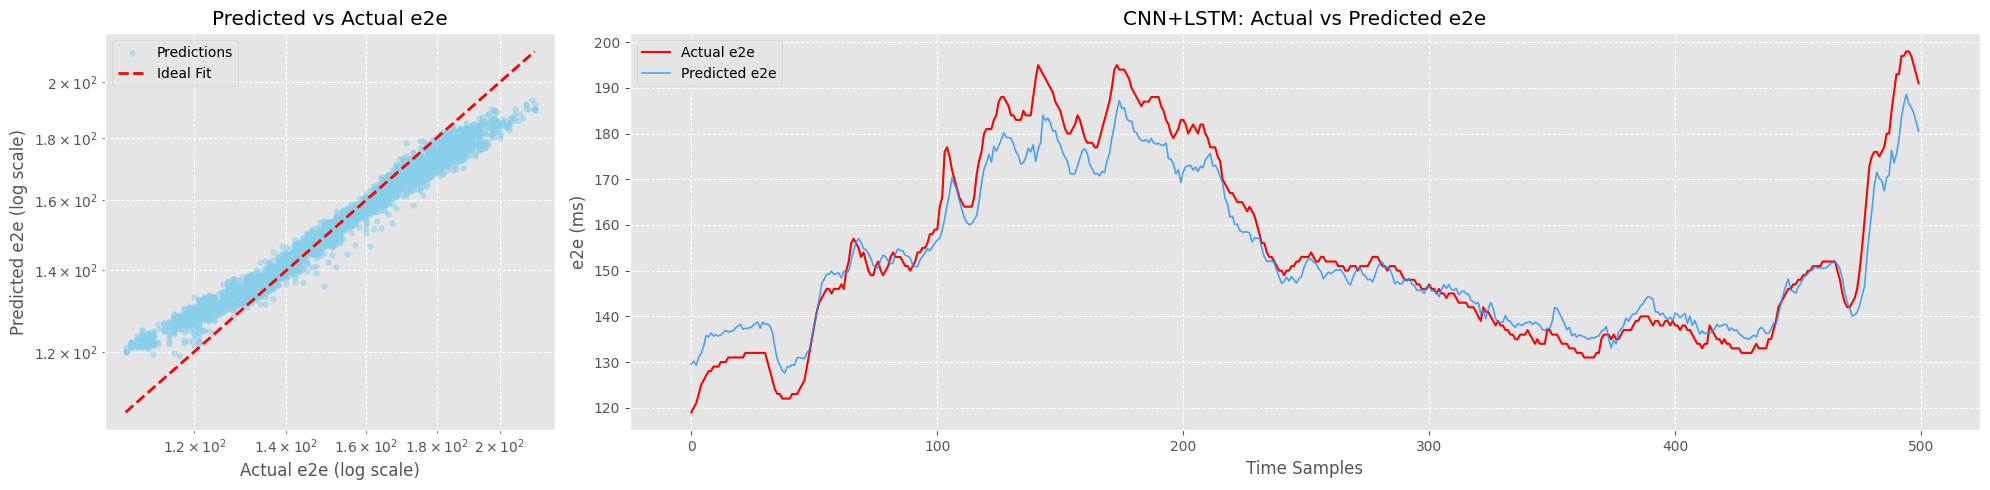

In [ ]:
avg.append(test(df1, model))

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE:  7.5896
MSE:  93.9988
RMSE: 9.6953
R²:   0.5602


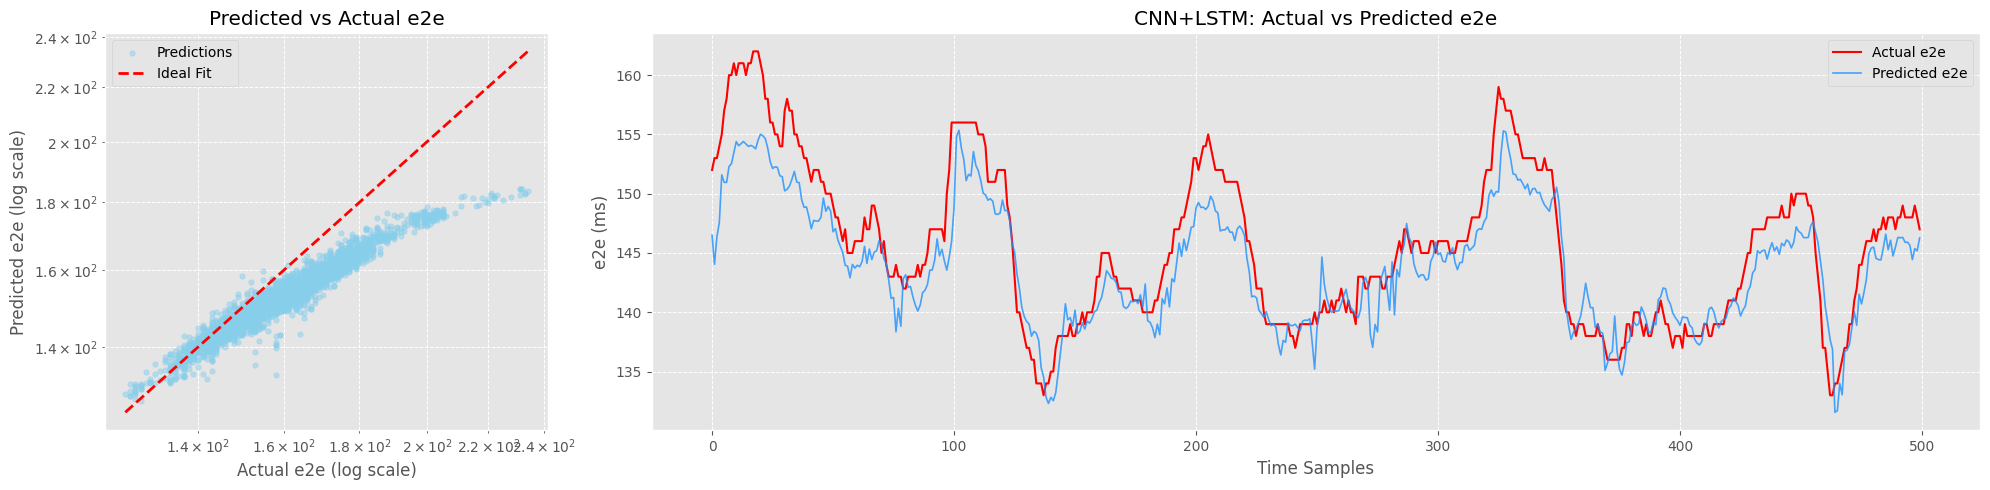

In [ ]:
avg.append(test(df2, model, zoom=slice(200, 700)))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAE:  4.7154
MSE:  41.4752
RMSE: 6.4401
R²:   0.9106


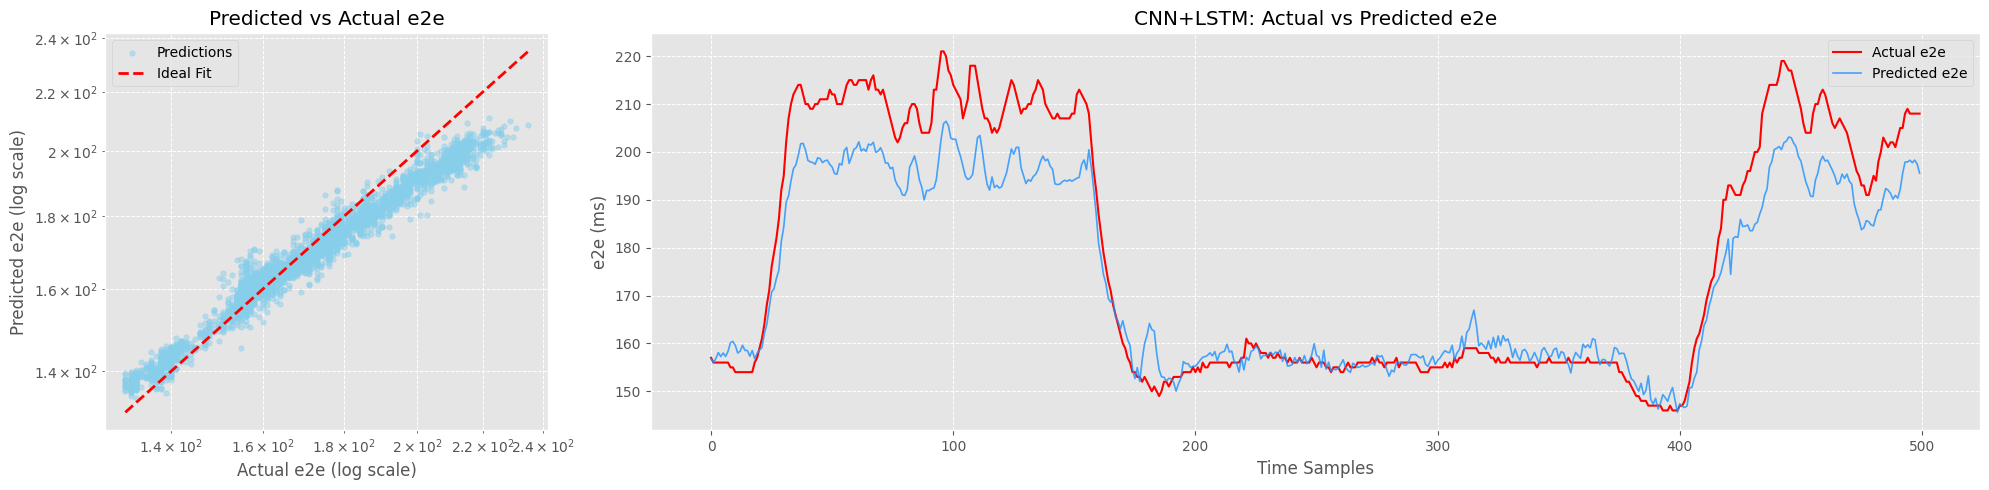

In [ ]:
avg.append(test(df3, model))

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE:  5.8499
MSE:  62.2355
RMSE: 7.8889
R²:   0.9058


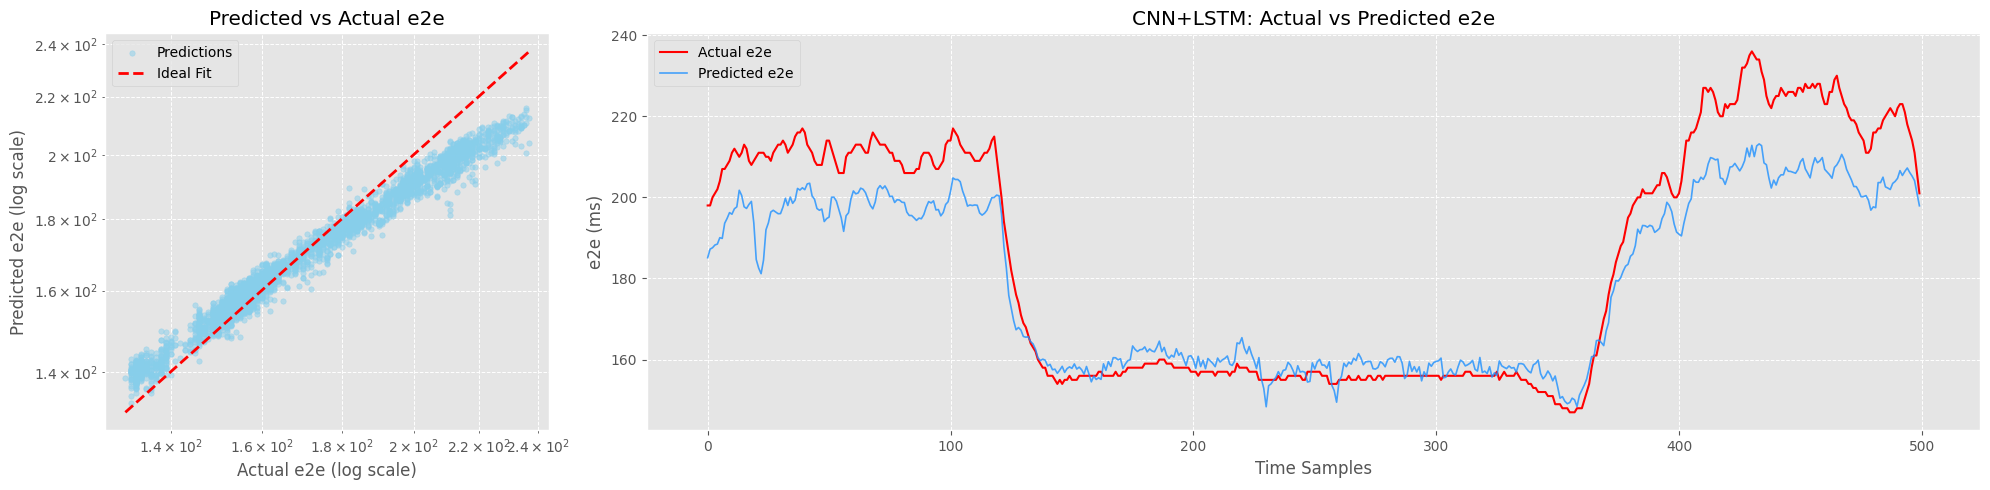

In [ ]:
avg.append(test(df4, model))

In [ ]:
arr = np.array(avg)
mean_vals = arr.mean(axis=0)

mae_avg, mse_avg, rmse_avg, r2_avg = mean_vals
print(f"avg - MAE:  {mae_avg:.4f}, MSE:  {mse_avg:.4f}, RMSE: {rmse_avg:.4f}, R²: {r2_avg:.4f}")


avg - MAE:  0.7736, MSE:  1.2672, RMSE: 1.1236, R²: 0.9966


1. CNN+LSTM(40 features) = avg - MAE:  2.5283, MSE:  11.8219, RMSE: 3.2759, R²: 0.9616
2. CNN+LSTM(1 feature) = avg - MAE:  0.7736, MSE:  1.2672, RMSE: 1.1236, R²: 0.9966


In [ ]:
#CNN+LSTM 1 FEATURE
def test2(df, model, zoom:slice = slice(1000, 1500)):
    #df['e2e'] = df['e2e_ema']
    df = df.drop(columns=['e2e_smooth', 'e2e_lowess', 'e2e_ema'])
    df['e2e'] = df['e2e'].astype(int)
    cols = ['e2e'] + [col for col in df.columns if col not in ['e2e']]
    df = df[cols]

    window_size = 5
    X, y = df_to_X_y(df, window_size)
    X.shape, y.shape

    total = len(X)
    split1 = int(total * 0.70)
    split2 = split1 + int(total * 0.15)
    X_train, y_train = X[:split1], y[:split1]
    X_val, y_val = X[split1:split2], y[split1:split2]
    X_test, y_test = X[split2:], y[split2:]

    nsamples, ntimesteps, nfeatures = X_train.shape
    X_train_2d = X_train.reshape(-1, nfeatures)
    X_val_2d   = X_val.reshape(-1, nfeatures)
    X_test_2d  = X_test.reshape(-1, nfeatures)

    scaler = StandardScaler()
    scaler.fit(X_train_2d)

    X_train_scaled = scaler.transform(X_train_2d).reshape(nsamples, ntimesteps, nfeatures)
    X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape)
    X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_val_scaled   = y_scaler.transform(y_val)
    y_test_scaled  = y_scaler.transform(y_test)

    #prediction
    y_val_pred_scaled = model.predict(X_val_scaled)

    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
    y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

    zoom_scatter = slice(None)
    y_true_scatter = y_val_original[zoom_scatter]
    y_pred_scatter = y_val_pred[zoom_scatter]

    mae = mean_absolute_error(y_true_scatter, y_pred_scatter)
    mse = mean_squared_error(y_true_scatter, y_pred_scatter)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_scatter, y_pred_scatter)

    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    zoom_ts = zoom
    y_true_ts = y_val_original[zoom_ts]
    y_pred_ts = y_val_pred[zoom_ts]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 3]})

    # Scatter MAE plot
    ax1.scatter(y_true_scatter, y_pred_scatter, alpha=0.5, color="skyblue", s=15, label="Predictions")
    mn = min(y_true_scatter.min(), y_pred_scatter.min())
    mx = max(y_true_scatter.max(), y_pred_scatter.max())
    ax1.plot([mn, mx], [mn, mx], "r--", linewidth=2, label="Ideal Fit")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Actual e2e (log scale)")
    ax1.set_ylabel("Predicted e2e (log scale)")
    ax1.set_title("Predicted vs Actual e2e")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.7)
    ax1.legend()

    # Time series plot
    ax2.plot(y_true_ts, label="Actual e2e", color="red", linewidth=1.5)
    ax2.plot(y_pred_ts, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)
    ax2.set_title("CNN+LSTM: Actual vs Predicted e2e")
    ax2.set_xlabel("Time Samples")
    ax2.set_ylabel("e2e (ms)")
    ax2.grid(True, linestyle="--", linewidth=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return (mae, mse, float(rmse), r2)

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE:  12.9956
MSE:  992.1836
RMSE: 31.4989
R²:   0.1263


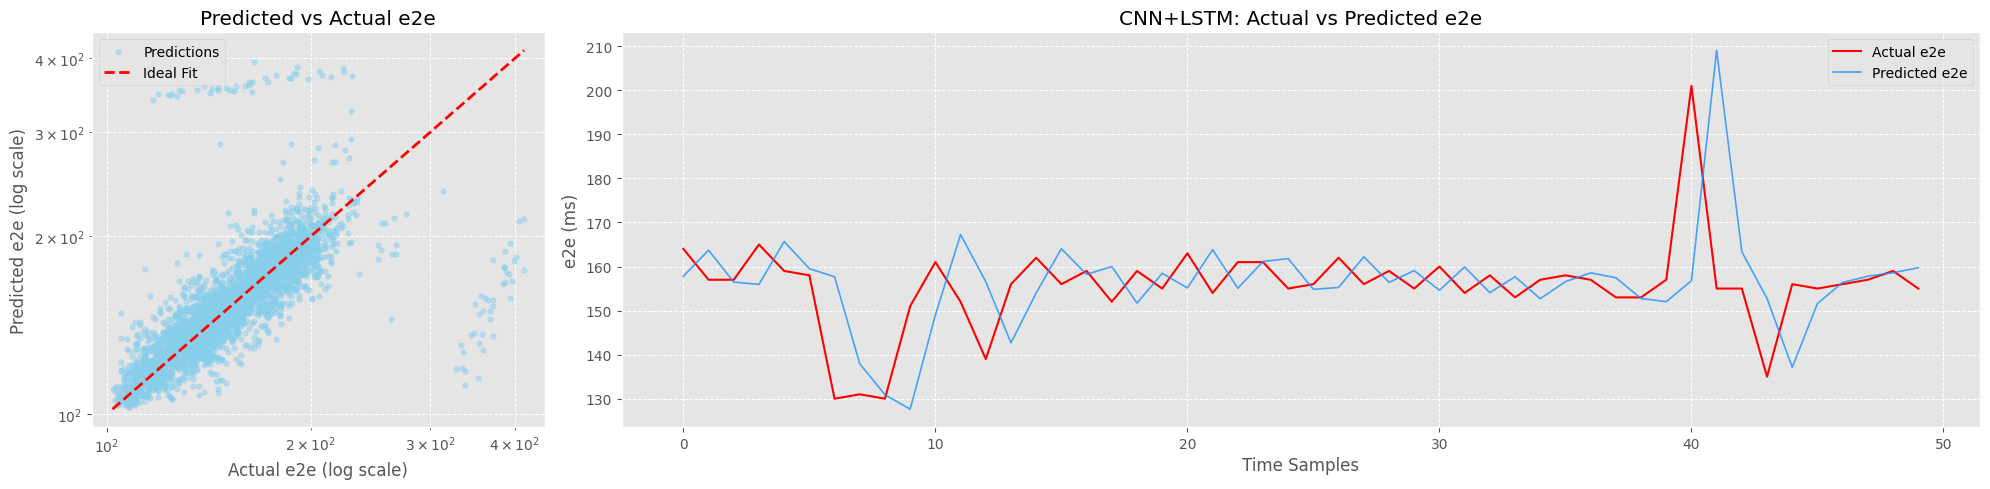

In [ ]:
avg.append(test2(df, model, zoom=slice(200,250)))

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE:  0.8146
MSE:  1.3379
RMSE: 1.1567
R²:   0.9975


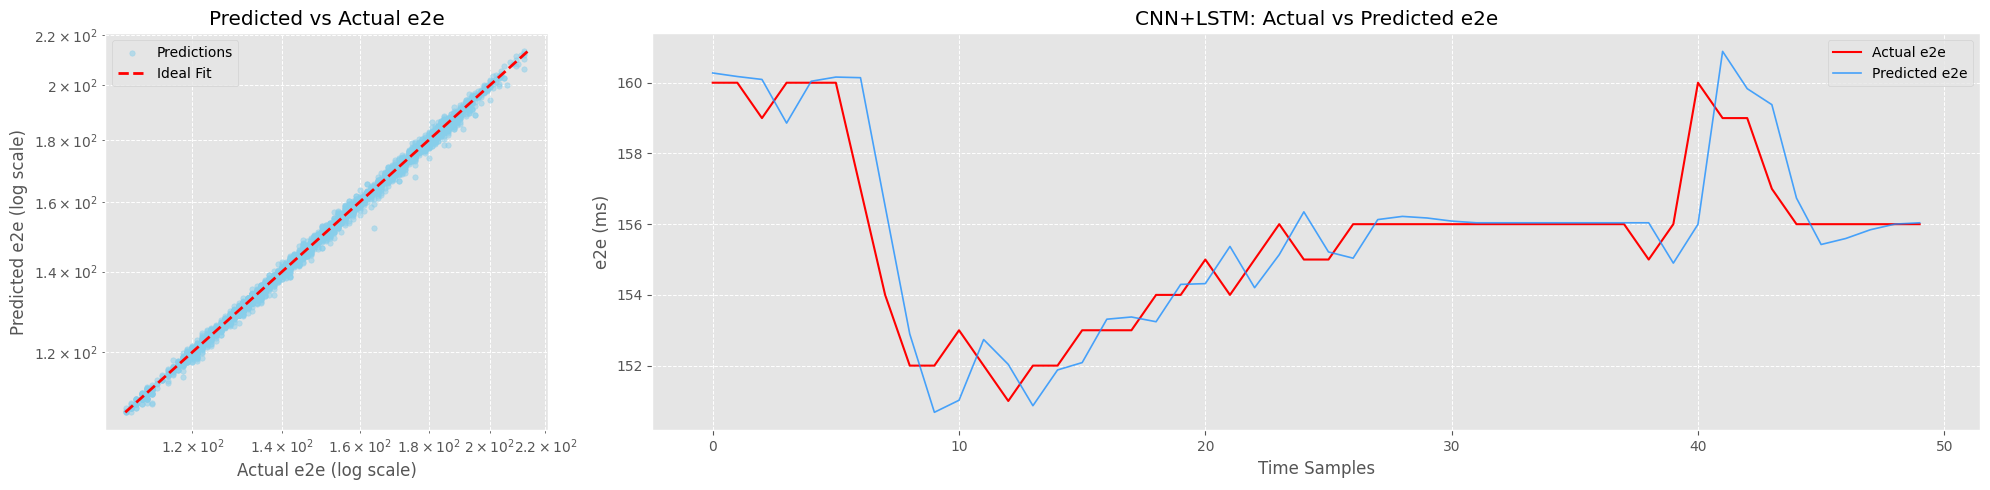

In [ ]:
avg.append(test(df, model, zoom=slice(200,250)))

# Graphs

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/tmp/ipython-input-216083030.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(fontsize=legend_size)
/tmp/ipython-input-216083030.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend(fontsize=legend_size)


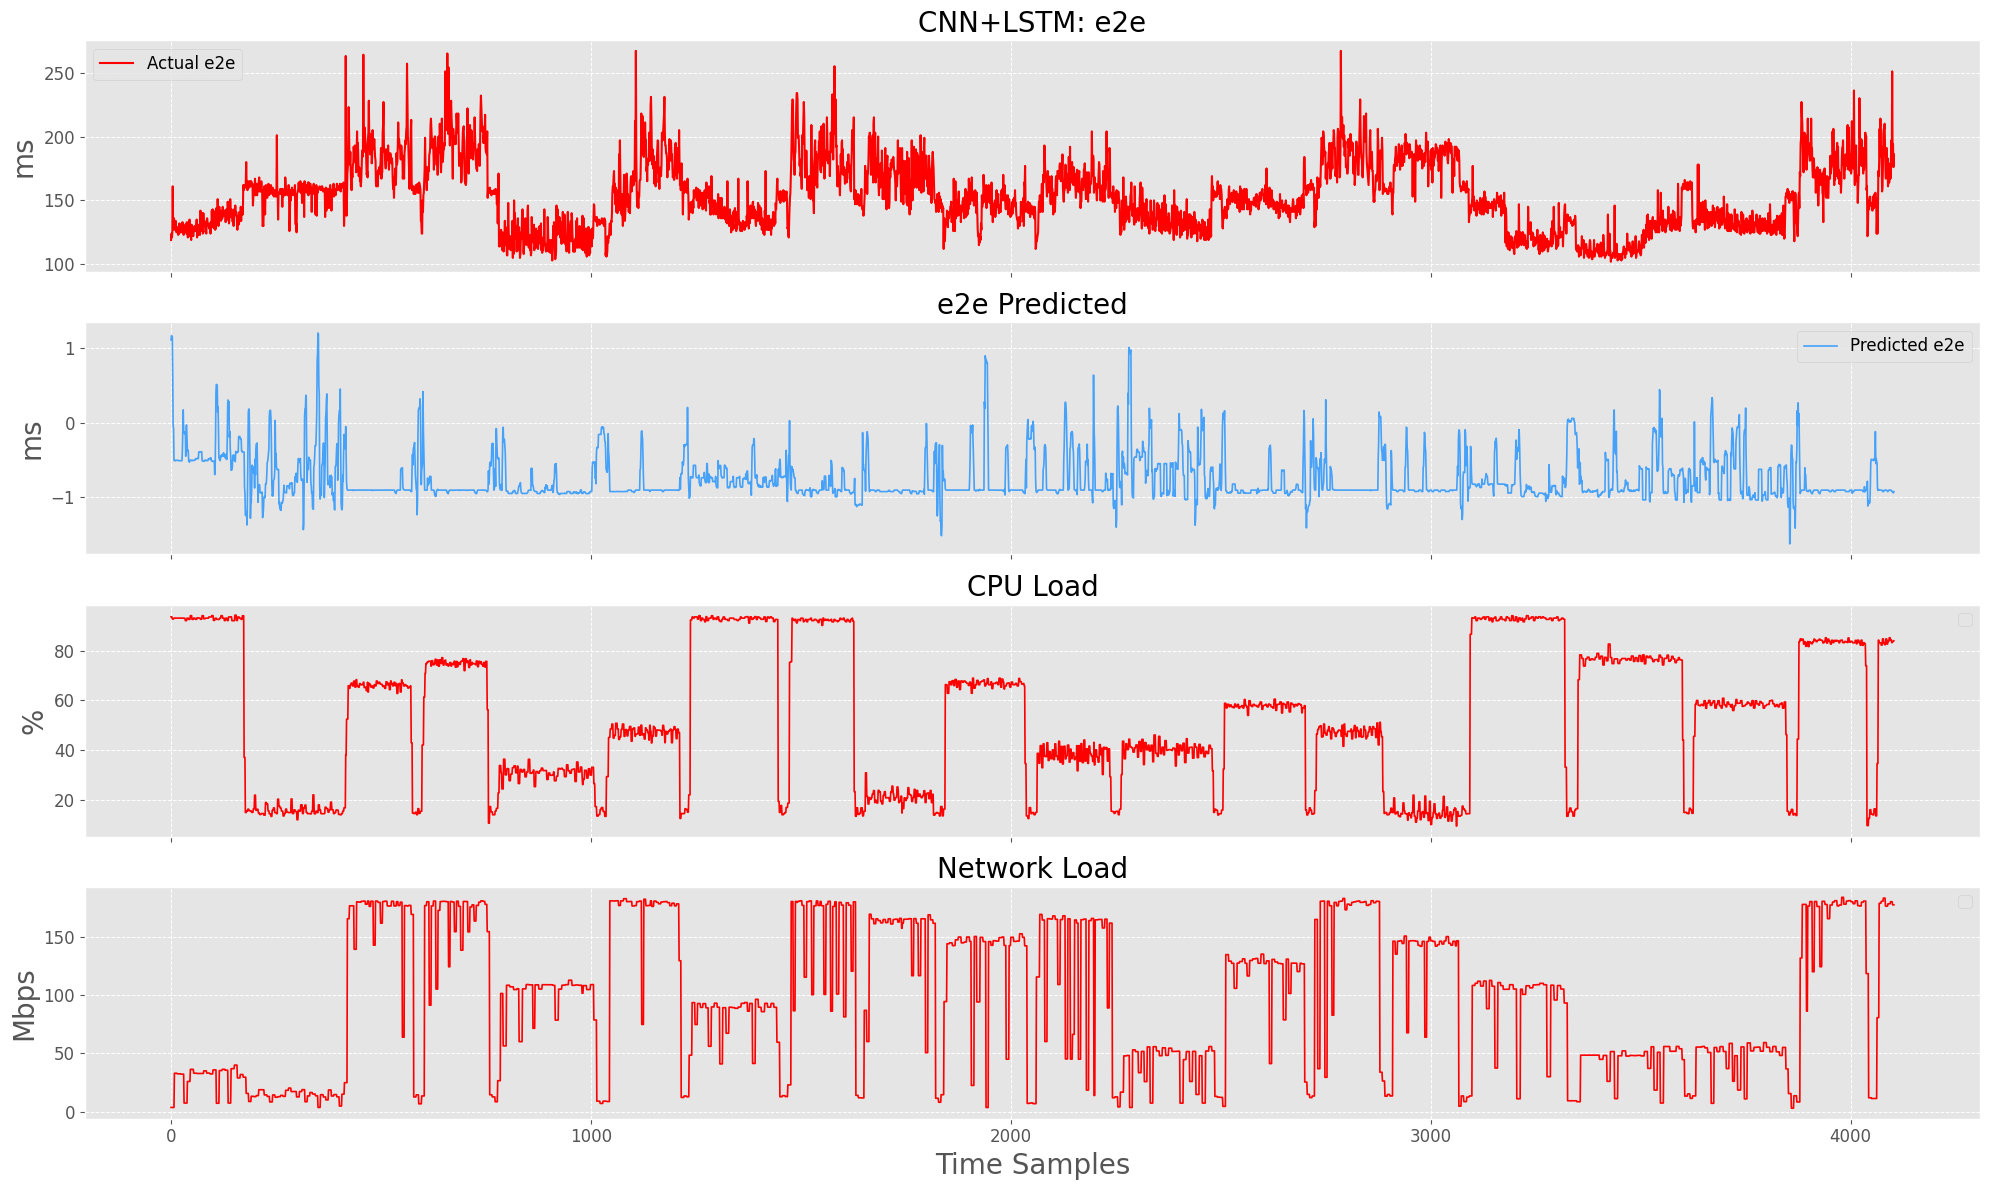

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for fonts
title_size = 20
label_size = 20
legend_size = 12
tick_size = 12

df_val = df.iloc[split1:split2].copy()
df_val.reset_index(drop=True, inplace=True)

y_val_pred = model.predict(X_val).flatten()
df_val['e2e_pred'] = y_val_pred


zoom = slice(None)
#zoom = slice(1750, 8200)

y_true_zoom = df_val['e2e'].iloc[zoom]
y_pred_zoom = df_val['e2e_pred'].iloc[zoom]
cpu_zoom = df_val['server_cpu_load_avg'].iloc[zoom]
net_zoom = df_val['up_throughput'].iloc[zoom]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12), sharex=True)

axes[0].plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
#axes[0].plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)
axes[0].set_ylabel("ms", fontsize=label_size)
axes[0].set_title("CNN+LSTM: e2e", fontsize=title_size)
axes[0].legend(fontsize=legend_size)
axes[0].tick_params(axis='both', labelsize=tick_size)
axes[0].grid(True, linestyle="--", linewidth=0.7)

axes[1].plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)
axes[1].set_ylabel("ms", fontsize=label_size)
axes[1].set_title("e2e Predicted", fontsize=title_size)
axes[1].legend(fontsize=legend_size)
axes[1].tick_params(axis='both', labelsize=tick_size)
axes[1].grid(True, linestyle="--", linewidth=0.7)

axes[2].plot(cpu_zoom, color="red", linewidth=1.2)
axes[2].set_ylabel("%", fontsize=label_size)
axes[2].set_title("CPU Load", fontsize=title_size)
axes[2].legend(fontsize=legend_size)
axes[2].tick_params(axis='both', labelsize=tick_size)
axes[2].grid(True, linestyle="--", linewidth=0.7)

axes[3].plot(net_zoom, color="red", linewidth=1.2)
axes[3].set_xlabel("Time Samples", fontsize=label_size)
axes[3].set_ylabel("Mbps", fontsize=label_size)
axes[3].set_title("Network Load", fontsize=title_size)
axes[3].legend(fontsize=legend_size)
axes[3].tick_params(axis='both', labelsize=tick_size)
axes[3].grid(True, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()


# PLOTS

In [ ]:
def my_plot(df, to_plot, zoom=slice(None), height=5):
    """
    Plots selected columns of a DataFrame with optional row slicing.

    Parameters:
    - df: pandas DataFrame
    - to_plot: list of column names to plot
    - zoom: slice object or tuple (start, stop), e.g., slice(100, 1000) or (100, 1000)
    """
    if isinstance(zoom, tuple):
        zoom = slice(*zoom)

    fig, ax = plt.subplots(figsize=(20, len(to_plot)*height), nrows=len(to_plot))

    if len(to_plot) == 1:
        ax = [ax]

    for i, col in enumerate(to_plot):
        df[col][zoom].plot(ax=ax[i])
        ax[i].set_xlabel(col, fontsize=20)

    plt.tight_layout()
    plt.show()

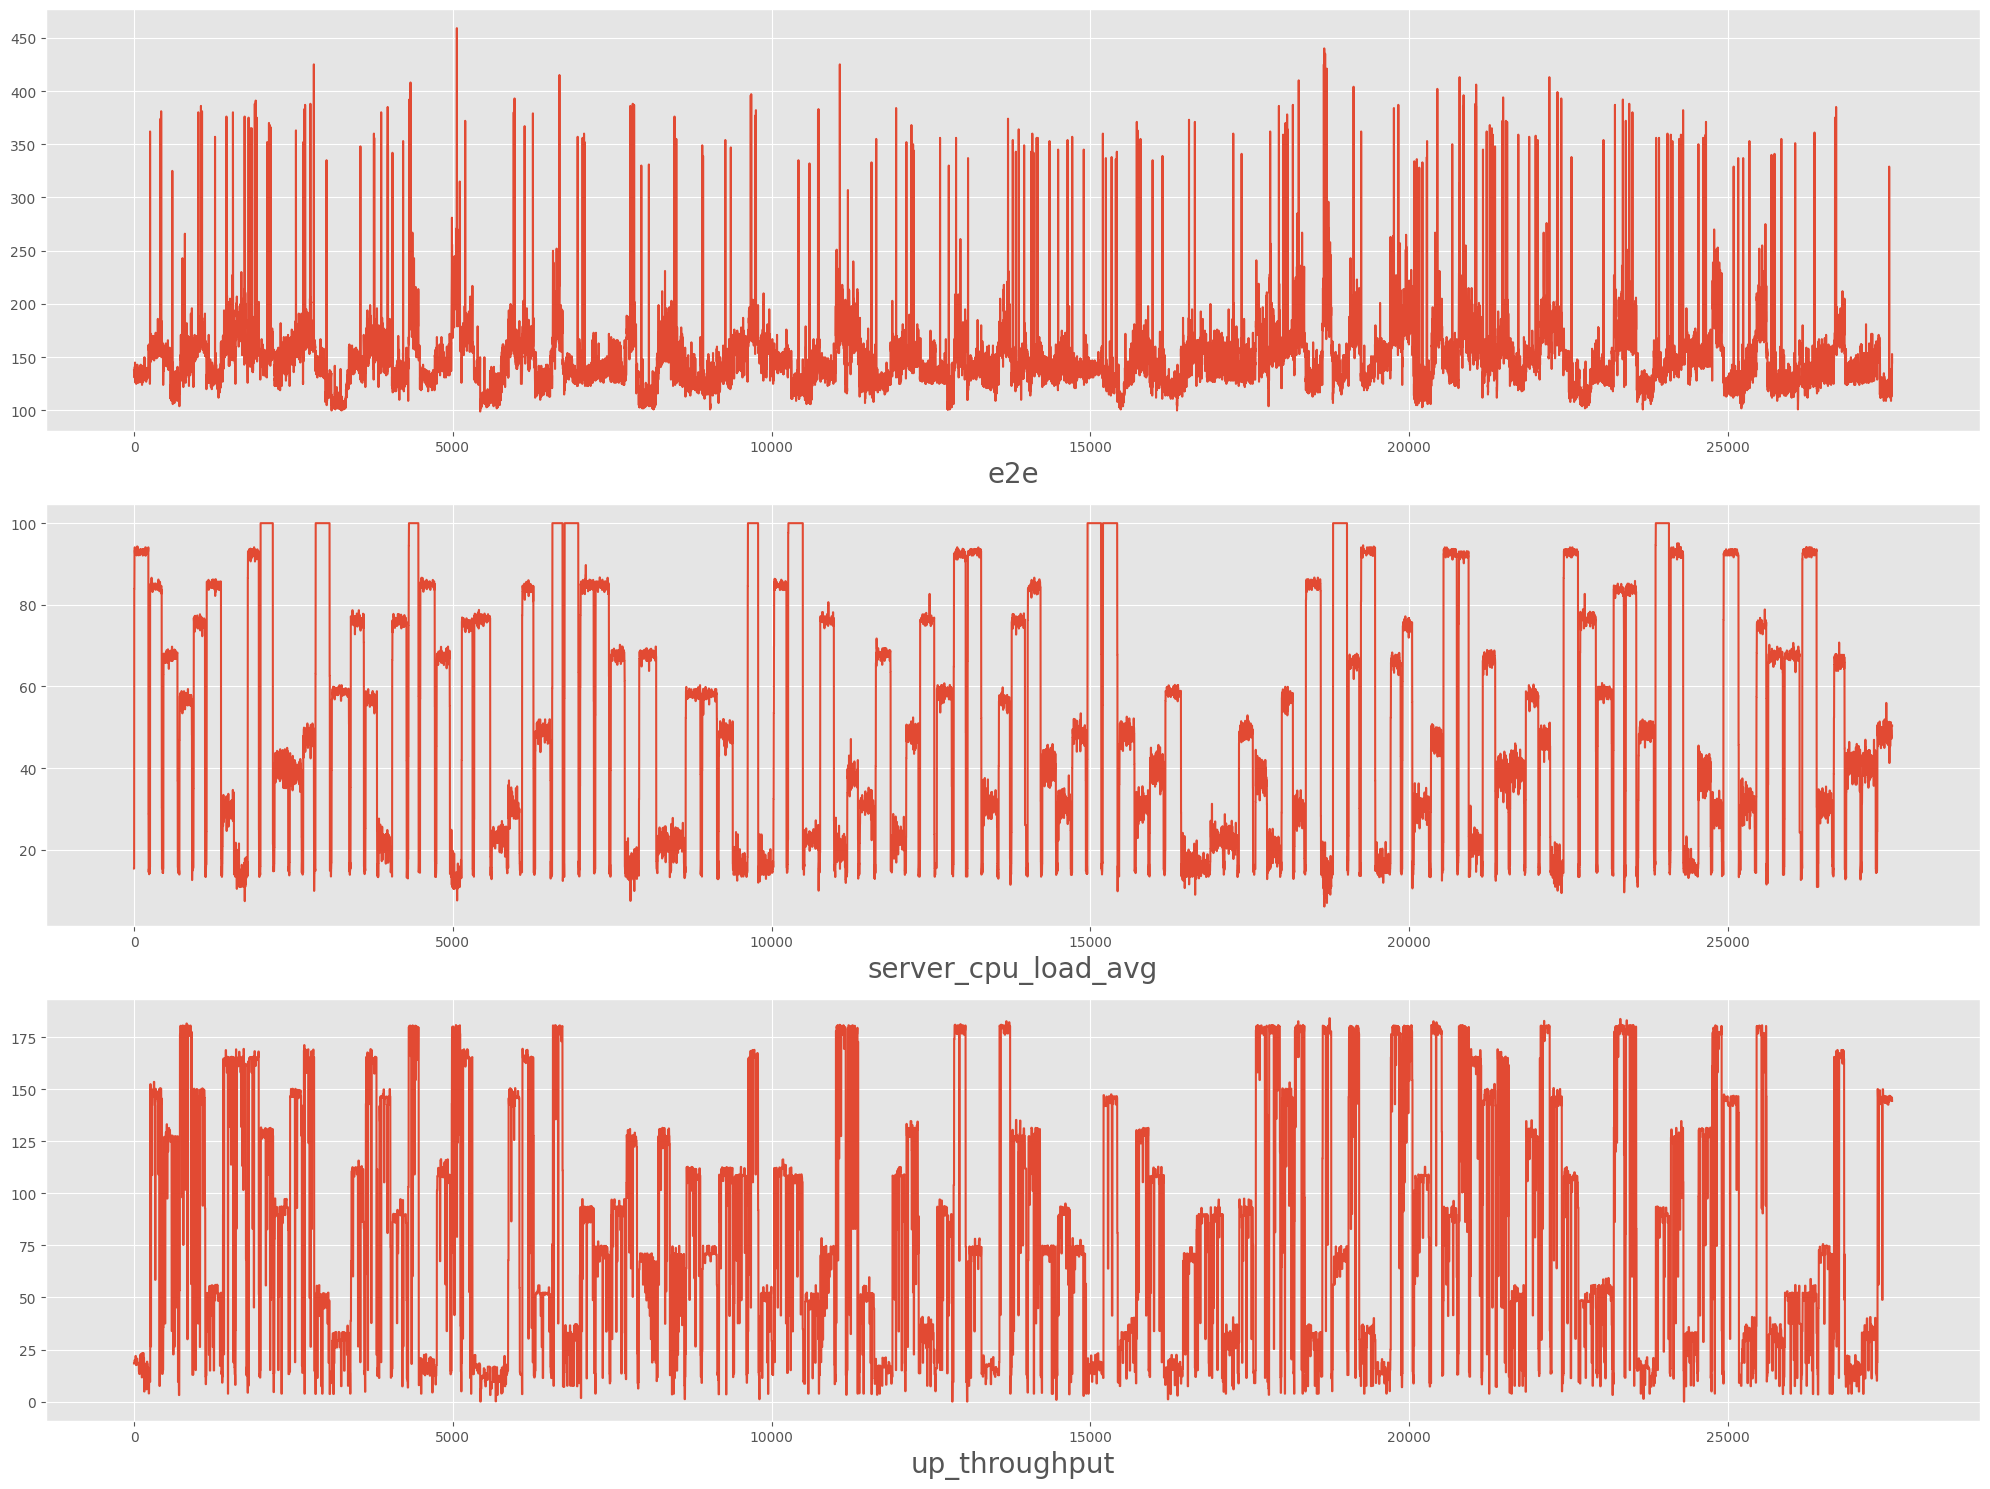

In [ ]:
my_plot(df1, ['server_cpu_load_avg', 'up_throughput'], zoom=slice(None), height=5)

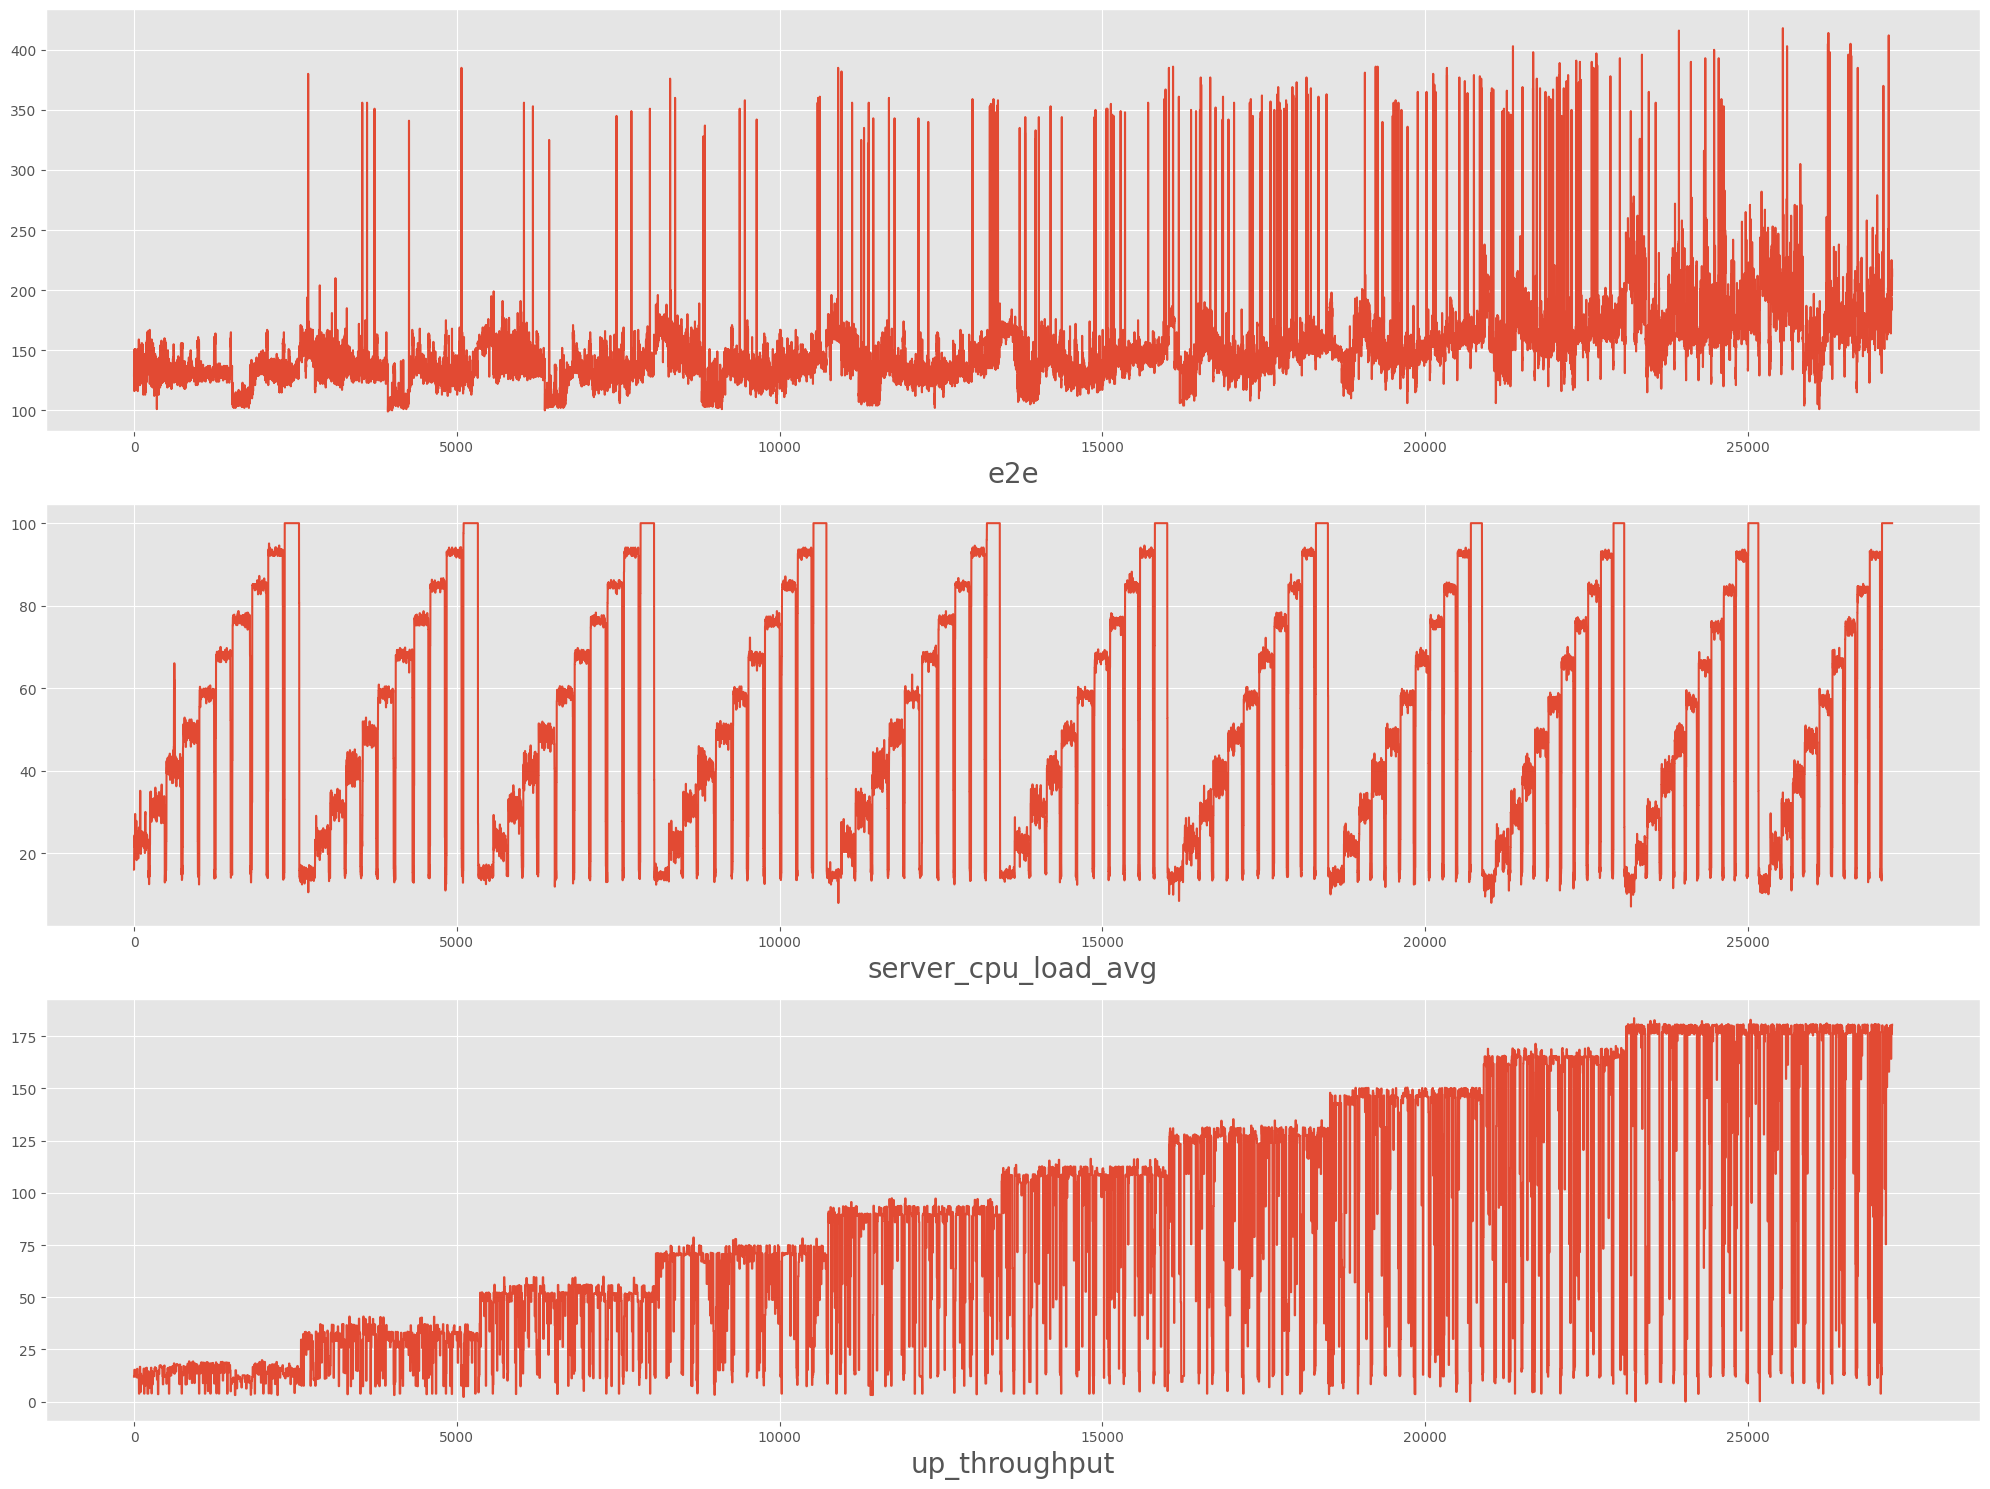

In [ ]:
my_plot(df2, ['server_cpu_load_avg', 'up_throughput'], zoom=slice(None), height=5)

In [ ]:
my_plot(df2, ['e2e', 'server_cpu_load_avg', 'up_throughput'], zoom=slice(None), height=5)